In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'features_clin' : [],
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_0_0_e_e_e_1_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3778099, 918)
(3778099, 8)
validation
(397815, 918)
(397815, 8)
test
(482242, 918)
(482242, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 918)]             0         


 dense (Dense)               (None, 2048)              1882112   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4670344 (17.82 MB)


Trainable params: 4670344 (17.82 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/38 [..............................] - ETA: 7:10 - loss: 2.2184 - STD: 0.0630 - MAE: 0.2184

 2/38 [>.............................] - ETA: 14s - loss: 2.1488 - STD: 0.0513 - MAE: 0.2176 

 3/38 [=>............................] - ETA: 17s - loss: 2.1177 - STD: 0.0465 - MAE: 0.2172

 4/38 [==>...........................] - ETA: 15s - loss: 2.1059 - STD: 0.0452 - MAE: 0.2171

 5/38 [==>...........................] - ETA: 15s - loss: 2.1018 - STD: 0.0456 - MAE: 0.2170

 6/38 [===>..........................] - ETA: 14s - loss: 2.0989 - STD: 0.0463 - MAE: 0.2168

 7/38 [====>.........................] - ETA: 13s - loss: 2.0954 - STD: 0.0465 - MAE: 0.2167

 8/38 [=====>........................] - ETA: 13s - loss: 2.0920 - STD: 0.0463 - MAE: 0.2167

 9/38 [======>.......................] - ETA: 13s - loss: 2.0881 - STD: 0.0456 - MAE: 0.2166

10/38 [======>.......................] - ETA: 34s - loss: 2.0853 - STD: 0.0446 - MAE: 0.2166

11/38 [=======>......................] - ETA: 31s - loss: 2.0822 - STD: 0.0433 - MAE: 0.2166

12/38 [========>.....................] - ETA: 28s - loss: 2.0797 - STD: 0.0422 - MAE: 0.2166

13/38 [=========>....................] - ETA: 25s - loss: 2.0778 - STD: 0.0412 - MAE: 0.2167

14/38 [==========>...................] - ETA: 23s - loss: 2.0764 - STD: 0.0405 - MAE: 0.2167

15/38 [==========>...................] - ETA: 22s - loss: 2.0754 - STD: 0.0399 - MAE: 0.2167

16/38 [===========>..................] - ETA: 20s - loss: 2.0743 - STD: 0.0394 - MAE: 0.2167

17/38 [============>.................] - ETA: 18s - loss: 2.0732 - STD: 0.0390 - MAE: 0.2167

18/38 [=============>................] - ETA: 17s - loss: 2.0722 - STD: 0.0385 - MAE: 0.2168

19/38 [==============>...............] - ETA: 15s - loss: 2.0712 - STD: 0.0380 - MAE: 0.2168

20/38 [==============>...............] - ETA: 14s - loss: 2.0701 - STD: 0.0376 - MAE: 0.2168

21/38 [===============>..............] - ETA: 13s - loss: 2.0691 - STD: 0.0373 - MAE: 0.2168

22/38 [================>.............] - ETA: 12s - loss: 2.0683 - STD: 0.0371 - MAE: 0.2168

23/38 [=================>............] - ETA: 11s - loss: 2.0674 - STD: 0.0369 - MAE: 0.2167

24/38 [=================>............] - ETA: 10s - loss: 2.0667 - STD: 0.0369 - MAE: 0.2167

25/38 [==================>...........] - ETA: 9s - loss: 2.0660 - STD: 0.0368 - MAE: 0.2167 

26/38 [===================>..........] - ETA: 8s - loss: 2.0653 - STD: 0.0368 - MAE: 0.2167

27/38 [====================>.........] - ETA: 7s - loss: 2.0646 - STD: 0.0367 - MAE: 0.2167

28/38 [=====================>........] - ETA: 7s - loss: 2.0638 - STD: 0.0367 - MAE: 0.2167

29/38 [=====================>........] - ETA: 6s - loss: 2.0628 - STD: 0.0366 - MAE: 0.2166

30/38 [======================>.......] - ETA: 5s - loss: 2.0618 - STD: 0.0364 - MAE: 0.2166

31/38 [=======================>......] - ETA: 4s - loss: 2.0607 - STD: 0.0363 - MAE: 0.2166

32/38 [========================>.....] - ETA: 4s - loss: 2.0595 - STD: 0.0361 - MAE: 0.2166

33/38 [=========================>....] - ETA: 3s - loss: 2.0581 - STD: 0.0360 - MAE: 0.2165

34/38 [=========================>....] - ETA: 2s - loss: 2.0565 - STD: 0.0359 - MAE: 0.2165

35/38 [==========================>...] - ETA: 1s - loss: 2.0548 - STD: 0.0359 - MAE: 0.2164

36/38 [===========================>..] - ETA: 1s - loss: 2.0528 - STD: 0.0360 - MAE: 0.2163

37/38 [============================>.] - ETA: 0s - loss: 2.0505 - STD: 0.0361 - MAE: 0.2163

38/38 [==============================] - ETA: 0s - loss: 2.0479 - STD: 0.0364 - MAE: 0.2161

38/38 [==============================] - 40s 763ms/step - loss: 2.0479 - STD: 0.0364 - MAE: 0.2161 - val_loss: 1.9294 - val_STD: 0.0515 - val_MAE: 0.2108


Epoch 2/10000


 1/38 [..............................] - ETA: 22s - loss: 1.9400 - STD: 0.0496 - MAE: 0.2114

 2/38 [>.............................] - ETA: 15s - loss: 1.9321 - STD: 0.0518 - MAE: 0.2109

 3/38 [=>............................] - ETA: 14s - loss: 1.9241 - STD: 0.0547 - MAE: 0.2104

 4/38 [==>...........................] - ETA: 15s - loss: 1.9172 - STD: 0.0562 - MAE: 0.2100

 5/38 [==>...........................] - ETA: 14s - loss: 1.9101 - STD: 0.0582 - MAE: 0.2096

 6/38 [===>..........................] - ETA: 14s - loss: 1.9028 - STD: 0.0596 - MAE: 0.2092

 7/38 [====>.........................] - ETA: 13s - loss: 1.8958 - STD: 0.0609 - MAE: 0.2088

 8/38 [=====>........................] - ETA: 13s - loss: 1.8892 - STD: 0.0621 - MAE: 0.2085

 9/38 [======>.......................] - ETA: 12s - loss: 1.8833 - STD: 0.0635 - MAE: 0.2081

10/38 [======>.......................] - ETA: 12s - loss: 1.8779 - STD: 0.0646 - MAE: 0.2078

11/38 [=======>......................] - ETA: 11s - loss: 1.8721 - STD: 0.0663 - MAE: 0.2074

12/38 [========>.....................] - ETA: 11s - loss: 1.8663 - STD: 0.0677 - MAE: 0.2070

13/38 [=========>....................] - ETA: 10s - loss: 1.8616 - STD: 0.0689 - MAE: 0.2067

14/38 [==========>...................] - ETA: 10s - loss: 1.8566 - STD: 0.0702 - MAE: 0.2063

15/38 [==========>...................] - ETA: 10s - loss: 1.8515 - STD: 0.0712 - MAE: 0.2060

16/38 [===========>..................] - ETA: 9s - loss: 1.8471 - STD: 0.0721 - MAE: 0.2057 

17/38 [============>.................] - ETA: 9s - loss: 1.8425 - STD: 0.0731 - MAE: 0.2054

18/38 [=============>................] - ETA: 8s - loss: 1.8380 - STD: 0.0741 - MAE: 0.2051

19/38 [==============>...............] - ETA: 8s - loss: 1.8338 - STD: 0.0750 - MAE: 0.2049

20/38 [==============>...............] - ETA: 7s - loss: 1.8293 - STD: 0.0760 - MAE: 0.2046

21/38 [===============>..............] - ETA: 7s - loss: 1.8250 - STD: 0.0769 - MAE: 0.2043

22/38 [================>.............] - ETA: 7s - loss: 1.8218 - STD: 0.0777 - MAE: 0.2040

23/38 [=================>............] - ETA: 6s - loss: 1.8175 - STD: 0.0785 - MAE: 0.2038

24/38 [=================>............] - ETA: 6s - loss: 1.8132 - STD: 0.0794 - MAE: 0.2035

25/38 [==================>...........] - ETA: 5s - loss: 1.8095 - STD: 0.0802 - MAE: 0.2032

26/38 [===================>..........] - ETA: 5s - loss: 1.8053 - STD: 0.0810 - MAE: 0.2030

27/38 [====================>.........] - ETA: 4s - loss: 1.8010 - STD: 0.0818 - MAE: 0.2027

28/38 [=====================>........] - ETA: 4s - loss: 1.7971 - STD: 0.0824 - MAE: 0.2025

29/38 [=====================>........] - ETA: 3s - loss: 1.7936 - STD: 0.0833 - MAE: 0.2022

30/38 [======================>.......] - ETA: 3s - loss: 1.7897 - STD: 0.0839 - MAE: 0.2020

31/38 [=======================>......] - ETA: 3s - loss: 1.7857 - STD: 0.0845 - MAE: 0.2018

32/38 [========================>.....] - ETA: 2s - loss: 1.7820 - STD: 0.0852 - MAE: 0.2016

33/38 [=========================>....] - ETA: 2s - loss: 1.7785 - STD: 0.0857 - MAE: 0.2014

34/38 [=========================>....] - ETA: 1s - loss: 1.7748 - STD: 0.0864 - MAE: 0.2012

35/38 [==========================>...] - ETA: 1s - loss: 1.7711 - STD: 0.0869 - MAE: 0.2010

36/38 [===========================>..] - ETA: 0s - loss: 1.7675 - STD: 0.0875 - MAE: 0.2008

37/38 [============================>.] - ETA: 0s - loss: 1.7642 - STD: 0.0881 - MAE: 0.2006

38/38 [==============================] - ETA: 0s - loss: 1.7610 - STD: 0.0885 - MAE: 0.2004

38/38 [==============================] - 19s 485ms/step - loss: 1.7610 - STD: 0.0885 - MAE: 0.2004 - val_loss: 1.6972 - val_STD: 0.1130 - val_MAE: 0.1941


Epoch 3/10000


 1/38 [..............................] - ETA: 34s - loss: 1.6374 - STD: 0.1107 - MAE: 0.1929

 2/38 [>.............................] - ETA: 15s - loss: 1.6296 - STD: 0.1091 - MAE: 0.1930

 3/38 [=>............................] - ETA: 14s - loss: 1.6252 - STD: 0.1094 - MAE: 0.1928

 4/38 [==>...........................] - ETA: 14s - loss: 1.6234 - STD: 0.1104 - MAE: 0.1925

 5/38 [==>...........................] - ETA: 13s - loss: 1.6216 - STD: 0.1099 - MAE: 0.1926

 6/38 [===>..........................] - ETA: 13s - loss: 1.6192 - STD: 0.1104 - MAE: 0.1924

 7/38 [====>.........................] - ETA: 13s - loss: 1.6154 - STD: 0.1107 - MAE: 0.1922

 8/38 [=====>........................] - ETA: 12s - loss: 1.6126 - STD: 0.1109 - MAE: 0.1920

 9/38 [======>.......................] - ETA: 12s - loss: 1.6101 - STD: 0.1114 - MAE: 0.1918

10/38 [======>.......................] - ETA: 12s - loss: 1.6063 - STD: 0.1114 - MAE: 0.1916

11/38 [=======>......................] - ETA: 11s - loss: 1.6019 - STD: 0.1118 - MAE: 0.1914

12/38 [========>.....................] - ETA: 11s - loss: 1.5974 - STD: 0.1123 - MAE: 0.1911

13/38 [=========>....................] - ETA: 10s - loss: 1.5935 - STD: 0.1125 - MAE: 0.1909

14/38 [==========>...................] - ETA: 10s - loss: 1.5890 - STD: 0.1130 - MAE: 0.1905

15/38 [==========>...................] - ETA: 9s - loss: 1.5840 - STD: 0.1136 - MAE: 0.1902 

16/38 [===========>..................] - ETA: 9s - loss: 1.5787 - STD: 0.1140 - MAE: 0.1899

17/38 [============>.................] - ETA: 9s - loss: 1.5732 - STD: 0.1146 - MAE: 0.1895

18/38 [=============>................] - ETA: 8s - loss: 1.5680 - STD: 0.1152 - MAE: 0.1892

19/38 [==============>...............] - ETA: 8s - loss: 1.5631 - STD: 0.1159 - MAE: 0.1888

20/38 [==============>...............] - ETA: 7s - loss: 1.5580 - STD: 0.1166 - MAE: 0.1884

21/38 [===============>..............] - ETA: 7s - loss: 1.5523 - STD: 0.1173 - MAE: 0.1880

22/38 [================>.............] - ETA: 6s - loss: 1.5474 - STD: 0.1179 - MAE: 0.1876

23/38 [=================>............] - ETA: 6s - loss: 1.5423 - STD: 0.1187 - MAE: 0.1872

24/38 [=================>............] - ETA: 6s - loss: 1.5367 - STD: 0.1195 - MAE: 0.1868

25/38 [==================>...........] - ETA: 5s - loss: 1.5316 - STD: 0.1202 - MAE: 0.1864

26/38 [===================>..........] - ETA: 5s - loss: 1.5267 - STD: 0.1210 - MAE: 0.1860

27/38 [====================>.........] - ETA: 4s - loss: 1.5217 - STD: 0.1217 - MAE: 0.1856

28/38 [=====================>........] - ETA: 4s - loss: 1.5171 - STD: 0.1225 - MAE: 0.1852

29/38 [=====================>........] - ETA: 3s - loss: 1.5132 - STD: 0.1232 - MAE: 0.1849

30/38 [======================>.......] - ETA: 3s - loss: 1.5090 - STD: 0.1240 - MAE: 0.1845

31/38 [=======================>......] - ETA: 3s - loss: 1.5046 - STD: 0.1246 - MAE: 0.1841

32/38 [========================>.....] - ETA: 2s - loss: 1.5005 - STD: 0.1254 - MAE: 0.1838

33/38 [=========================>....] - ETA: 2s - loss: 1.4962 - STD: 0.1260 - MAE: 0.1834

34/38 [=========================>....] - ETA: 1s - loss: 1.4924 - STD: 0.1266 - MAE: 0.1831

35/38 [==========================>...] - ETA: 1s - loss: 1.4883 - STD: 0.1272 - MAE: 0.1827

36/38 [===========================>..] - ETA: 0s - loss: 1.4851 - STD: 0.1278 - MAE: 0.1824

37/38 [============================>.] - ETA: 0s - loss: 1.4814 - STD: 0.1283 - MAE: 0.1821

38/38 [==============================] - ETA: 0s - loss: 1.4776 - STD: 0.1289 - MAE: 0.1818

38/38 [==============================] - 18s 473ms/step - loss: 1.4776 - STD: 0.1289 - MAE: 0.1818 - val_loss: 1.4421 - val_STD: 0.1521 - val_MAE: 0.1737


Epoch 4/10000


 1/38 [..............................] - ETA: 32s - loss: 1.3337 - STD: 0.1505 - MAE: 0.1697

 2/38 [>.............................] - ETA: 14s - loss: 1.3339 - STD: 0.1507 - MAE: 0.1696

 3/38 [=>............................] - ETA: 14s - loss: 1.3316 - STD: 0.1509 - MAE: 0.1694

 4/38 [==>...........................] - ETA: 14s - loss: 1.3298 - STD: 0.1514 - MAE: 0.1692

 5/38 [==>...........................] - ETA: 13s - loss: 1.3292 - STD: 0.1516 - MAE: 0.1691

 6/38 [===>..........................] - ETA: 13s - loss: 1.3272 - STD: 0.1517 - MAE: 0.1689

 7/38 [====>.........................] - ETA: 13s - loss: 1.3263 - STD: 0.1523 - MAE: 0.1687

 8/38 [=====>........................] - ETA: 12s - loss: 1.3261 - STD: 0.1523 - MAE: 0.1686

 9/38 [======>.......................] - ETA: 12s - loss: 1.3243 - STD: 0.1527 - MAE: 0.1684

10/38 [======>.......................] - ETA: 11s - loss: 1.3224 - STD: 0.1531 - MAE: 0.1682

11/38 [=======>......................] - ETA: 11s - loss: 1.3208 - STD: 0.1533 - MAE: 0.1680

12/38 [========>.....................] - ETA: 11s - loss: 1.3188 - STD: 0.1537 - MAE: 0.1678

13/38 [=========>....................] - ETA: 10s - loss: 1.3176 - STD: 0.1541 - MAE: 0.1676

14/38 [==========>...................] - ETA: 10s - loss: 1.3165 - STD: 0.1544 - MAE: 0.1675

15/38 [==========>...................] - ETA: 9s - loss: 1.3150 - STD: 0.1546 - MAE: 0.1673 

16/38 [===========>..................] - ETA: 9s - loss: 1.3137 - STD: 0.1549 - MAE: 0.1671

17/38 [============>.................] - ETA: 9s - loss: 1.3125 - STD: 0.1550 - MAE: 0.1670

18/38 [=============>................] - ETA: 8s - loss: 1.3109 - STD: 0.1552 - MAE: 0.1669

19/38 [==============>...............] - ETA: 8s - loss: 1.3092 - STD: 0.1555 - MAE: 0.1667

20/38 [==============>...............] - ETA: 7s - loss: 1.3076 - STD: 0.1557 - MAE: 0.1665

21/38 [===============>..............] - ETA: 7s - loss: 1.3059 - STD: 0.1560 - MAE: 0.1663

22/38 [================>.............] - ETA: 6s - loss: 1.3048 - STD: 0.1563 - MAE: 0.1662

23/38 [=================>............] - ETA: 6s - loss: 1.3043 - STD: 0.1566 - MAE: 0.1660

24/38 [=================>............] - ETA: 6s - loss: 1.3041 - STD: 0.1568 - MAE: 0.1660

25/38 [==================>...........] - ETA: 5s - loss: 1.3039 - STD: 0.1572 - MAE: 0.1658

26/38 [===================>..........] - ETA: 5s - loss: 1.3032 - STD: 0.1573 - MAE: 0.1657

27/38 [====================>.........] - ETA: 4s - loss: 1.3017 - STD: 0.1575 - MAE: 0.1656

28/38 [=====================>........] - ETA: 4s - loss: 1.3007 - STD: 0.1578 - MAE: 0.1654

29/38 [=====================>........] - ETA: 3s - loss: 1.3003 - STD: 0.1580 - MAE: 0.1653

30/38 [======================>.......] - ETA: 3s - loss: 1.2995 - STD: 0.1583 - MAE: 0.1652

31/38 [=======================>......] - ETA: 2s - loss: 1.2982 - STD: 0.1586 - MAE: 0.1651

32/38 [========================>.....] - ETA: 2s - loss: 1.2971 - STD: 0.1588 - MAE: 0.1649

33/38 [=========================>....] - ETA: 2s - loss: 1.2966 - STD: 0.1590 - MAE: 0.1648

34/38 [=========================>....] - ETA: 1s - loss: 1.2960 - STD: 0.1592 - MAE: 0.1647

35/38 [==========================>...] - ETA: 1s - loss: 1.2949 - STD: 0.1594 - MAE: 0.1646

36/38 [===========================>..] - ETA: 0s - loss: 1.2939 - STD: 0.1596 - MAE: 0.1645

37/38 [============================>.] - ETA: 0s - loss: 1.2931 - STD: 0.1598 - MAE: 0.1644

38/38 [==============================] - ETA: 0s - loss: 1.2922 - STD: 0.1600 - MAE: 0.1643

38/38 [==============================] - 18s 470ms/step - loss: 1.2922 - STD: 0.1600 - MAE: 0.1643 - val_loss: 1.3659 - val_STD: 0.1704 - val_MAE: 0.1637


Epoch 5/10000


 1/38 [..............................] - ETA: 30s - loss: 1.2481 - STD: 0.1680 - MAE: 0.1594

 2/38 [>.............................] - ETA: 15s - loss: 1.2500 - STD: 0.1678 - MAE: 0.1595

 3/38 [=>............................] - ETA: 14s - loss: 1.2519 - STD: 0.1680 - MAE: 0.1595

 4/38 [==>...........................] - ETA: 14s - loss: 1.2505 - STD: 0.1682 - MAE: 0.1594

 5/38 [==>...........................] - ETA: 14s - loss: 1.2499 - STD: 0.1681 - MAE: 0.1594

 6/38 [===>..........................] - ETA: 14s - loss: 1.2485 - STD: 0.1683 - MAE: 0.1593

 7/38 [====>.........................] - ETA: 13s - loss: 1.2478 - STD: 0.1683 - MAE: 0.1592

 8/38 [=====>........................] - ETA: 13s - loss: 1.2474 - STD: 0.1685 - MAE: 0.1592

 9/38 [======>.......................] - ETA: 12s - loss: 1.2467 - STD: 0.1686 - MAE: 0.1591

10/38 [======>.......................] - ETA: 12s - loss: 1.2459 - STD: 0.1686 - MAE: 0.1590

11/38 [=======>......................] - ETA: 12s - loss: 1.2453 - STD: 0.1687 - MAE: 0.1590

12/38 [========>.....................] - ETA: 11s - loss: 1.2441 - STD: 0.1688 - MAE: 0.1589

13/38 [=========>....................] - ETA: 11s - loss: 1.2432 - STD: 0.1689 - MAE: 0.1588

14/38 [==========>...................] - ETA: 10s - loss: 1.2425 - STD: 0.1690 - MAE: 0.1587

15/38 [==========>...................] - ETA: 10s - loss: 1.2417 - STD: 0.1691 - MAE: 0.1587

16/38 [===========>..................] - ETA: 9s - loss: 1.2407 - STD: 0.1693 - MAE: 0.1586 

17/38 [============>.................] - ETA: 9s - loss: 1.2395 - STD: 0.1694 - MAE: 0.1585

18/38 [=============>................] - ETA: 9s - loss: 1.2389 - STD: 0.1696 - MAE: 0.1584

19/38 [==============>...............] - ETA: 8s - loss: 1.2384 - STD: 0.1697 - MAE: 0.1583

20/38 [==============>...............] - ETA: 8s - loss: 1.2380 - STD: 0.1698 - MAE: 0.1582

21/38 [===============>..............] - ETA: 7s - loss: 1.2376 - STD: 0.1699 - MAE: 0.1582

22/38 [================>.............] - ETA: 7s - loss: 1.2372 - STD: 0.1700 - MAE: 0.1581

23/38 [=================>............] - ETA: 6s - loss: 1.2369 - STD: 0.1702 - MAE: 0.1580

24/38 [=================>............] - ETA: 6s - loss: 1.2363 - STD: 0.1702 - MAE: 0.1580

25/38 [==================>...........] - ETA: 5s - loss: 1.2356 - STD: 0.1704 - MAE: 0.1579

26/38 [===================>..........] - ETA: 5s - loss: 1.2347 - STD: 0.1705 - MAE: 0.1578

27/38 [====================>.........] - ETA: 5s - loss: 1.2341 - STD: 0.1706 - MAE: 0.1577

28/38 [=====================>........] - ETA: 4s - loss: 1.2336 - STD: 0.1707 - MAE: 0.1577

29/38 [=====================>........] - ETA: 4s - loss: 1.2335 - STD: 0.1708 - MAE: 0.1577

30/38 [======================>.......] - ETA: 3s - loss: 1.2333 - STD: 0.1709 - MAE: 0.1576

31/38 [=======================>......] - ETA: 3s - loss: 1.2330 - STD: 0.1710 - MAE: 0.1575

32/38 [========================>.....] - ETA: 2s - loss: 1.2326 - STD: 0.1711 - MAE: 0.1575

33/38 [=========================>....] - ETA: 2s - loss: 1.2324 - STD: 0.1712 - MAE: 0.1574

34/38 [=========================>....] - ETA: 1s - loss: 1.2324 - STD: 0.1713 - MAE: 0.1574

35/38 [==========================>...] - ETA: 1s - loss: 1.2317 - STD: 0.1714 - MAE: 0.1573

36/38 [===========================>..] - ETA: 0s - loss: 1.2308 - STD: 0.1715 - MAE: 0.1572

37/38 [============================>.] - ETA: 0s - loss: 1.2304 - STD: 0.1716 - MAE: 0.1572

38/38 [==============================] - ETA: 0s - loss: 1.2302 - STD: 0.1717 - MAE: 0.1571

38/38 [==============================] - 21s 533ms/step - loss: 1.2302 - STD: 0.1717 - MAE: 0.1571 - val_loss: 1.3352 - val_STD: 0.1765 - val_MAE: 0.1597


Epoch 6/10000


 1/38 [..............................] - ETA: 31s - loss: 1.2008 - STD: 0.1730 - MAE: 0.1552

 2/38 [>.............................] - ETA: 19s - loss: 1.1953 - STD: 0.1735 - MAE: 0.1547

 3/38 [=>............................] - ETA: 17s - loss: 1.1981 - STD: 0.1746 - MAE: 0.1545

 4/38 [==>...........................] - ETA: 17s - loss: 1.2001 - STD: 0.1745 - MAE: 0.1546

 5/38 [==>...........................] - ETA: 17s - loss: 1.1983 - STD: 0.1750 - MAE: 0.1543

 6/38 [===>..........................] - ETA: 16s - loss: 1.1987 - STD: 0.1756 - MAE: 0.1542

 7/38 [====>.........................] - ETA: 16s - loss: 1.1988 - STD: 0.1756 - MAE: 0.1541

 8/38 [=====>........................] - ETA: 15s - loss: 1.1977 - STD: 0.1760 - MAE: 0.1540

 9/38 [======>.......................] - ETA: 14s - loss: 1.1966 - STD: 0.1762 - MAE: 0.1538

10/38 [======>.......................] - ETA: 14s - loss: 1.1959 - STD: 0.1762 - MAE: 0.1538

11/38 [=======>......................] - ETA: 13s - loss: 1.1949 - STD: 0.1765 - MAE: 0.1537

12/38 [========>.....................] - ETA: 13s - loss: 1.1943 - STD: 0.1765 - MAE: 0.1536

13/38 [=========>....................] - ETA: 13s - loss: 1.1933 - STD: 0.1766 - MAE: 0.1535

14/38 [==========>...................] - ETA: 12s - loss: 1.1929 - STD: 0.1768 - MAE: 0.1535

15/38 [==========>...................] - ETA: 12s - loss: 1.1930 - STD: 0.1768 - MAE: 0.1534

16/38 [===========>..................] - ETA: 11s - loss: 1.1930 - STD: 0.1770 - MAE: 0.1534

17/38 [============>.................] - ETA: 11s - loss: 1.1929 - STD: 0.1771 - MAE: 0.1533

18/38 [=============>................] - ETA: 10s - loss: 1.1931 - STD: 0.1772 - MAE: 0.1533

19/38 [==============>...............] - ETA: 10s - loss: 1.1930 - STD: 0.1773 - MAE: 0.1533

20/38 [==============>...............] - ETA: 9s - loss: 1.1929 - STD: 0.1775 - MAE: 0.1532 

21/38 [===============>..............] - ETA: 9s - loss: 1.1931 - STD: 0.1776 - MAE: 0.1532

22/38 [================>.............] - ETA: 8s - loss: 1.1929 - STD: 0.1778 - MAE: 0.1531

23/38 [=================>............] - ETA: 8s - loss: 1.1920 - STD: 0.1779 - MAE: 0.1530

24/38 [=================>............] - ETA: 7s - loss: 1.1913 - STD: 0.1780 - MAE: 0.1529

25/38 [==================>...........] - ETA: 7s - loss: 1.1907 - STD: 0.1781 - MAE: 0.1529

26/38 [===================>..........] - ETA: 6s - loss: 1.1901 - STD: 0.1781 - MAE: 0.1528

27/38 [====================>.........] - ETA: 5s - loss: 1.1898 - STD: 0.1782 - MAE: 0.1528

28/38 [=====================>........] - ETA: 5s - loss: 1.1895 - STD: 0.1783 - MAE: 0.1527

29/38 [=====================>........] - ETA: 4s - loss: 1.1892 - STD: 0.1784 - MAE: 0.1527

30/38 [======================>.......] - ETA: 4s - loss: 1.1888 - STD: 0.1785 - MAE: 0.1526

31/38 [=======================>......] - ETA: 3s - loss: 1.1882 - STD: 0.1786 - MAE: 0.1526

32/38 [========================>.....] - ETA: 3s - loss: 1.1875 - STD: 0.1787 - MAE: 0.1525

33/38 [=========================>....] - ETA: 2s - loss: 1.1869 - STD: 0.1788 - MAE: 0.1524

34/38 [=========================>....] - ETA: 2s - loss: 1.1866 - STD: 0.1789 - MAE: 0.1524

35/38 [==========================>...] - ETA: 1s - loss: 1.1863 - STD: 0.1790 - MAE: 0.1523

36/38 [===========================>..] - ETA: 1s - loss: 1.1859 - STD: 0.1791 - MAE: 0.1523

37/38 [============================>.] - ETA: 0s - loss: 1.1854 - STD: 0.1791 - MAE: 0.1523

38/38 [==============================] - ETA: 0s - loss: 1.1848 - STD: 0.1792 - MAE: 0.1522

38/38 [==============================] - 23s 600ms/step - loss: 1.1848 - STD: 0.1792 - MAE: 0.1522 - val_loss: 1.3229 - val_STD: 0.1871 - val_MAE: 0.1554


Epoch 7/10000


 1/38 [..............................] - ETA: 31s - loss: 1.1621 - STD: 0.1823 - MAE: 0.1498

 2/38 [>.............................] - ETA: 15s - loss: 1.1646 - STD: 0.1827 - MAE: 0.1499

 3/38 [=>............................] - ETA: 16s - loss: 1.1686 - STD: 0.1830 - MAE: 0.1500

 4/38 [==>...........................] - ETA: 15s - loss: 1.1691 - STD: 0.1831 - MAE: 0.1500

 5/38 [==>...........................] - ETA: 16s - loss: 1.1677 - STD: 0.1832 - MAE: 0.1499

 6/38 [===>..........................] - ETA: 15s - loss: 1.1665 - STD: 0.1833 - MAE: 0.1498

 7/38 [====>.........................] - ETA: 14s - loss: 1.1652 - STD: 0.1833 - MAE: 0.1497

 8/38 [=====>........................] - ETA: 14s - loss: 1.1643 - STD: 0.1833 - MAE: 0.1497

 9/38 [======>.......................] - ETA: 13s - loss: 1.1632 - STD: 0.1832 - MAE: 0.1496

10/38 [======>.......................] - ETA: 13s - loss: 1.1632 - STD: 0.1833 - MAE: 0.1496

11/38 [=======>......................] - ETA: 12s - loss: 1.1629 - STD: 0.1833 - MAE: 0.1496

12/38 [========>.....................] - ETA: 12s - loss: 1.1634 - STD: 0.1833 - MAE: 0.1496

13/38 [=========>....................] - ETA: 11s - loss: 1.1637 - STD: 0.1835 - MAE: 0.1496

14/38 [==========>...................] - ETA: 11s - loss: 1.1641 - STD: 0.1834 - MAE: 0.1497

15/38 [==========>...................] - ETA: 10s - loss: 1.1655 - STD: 0.1836 - MAE: 0.1497

16/38 [===========>..................] - ETA: 10s - loss: 1.1677 - STD: 0.1835 - MAE: 0.1498

17/38 [============>.................] - ETA: 9s - loss: 1.1681 - STD: 0.1838 - MAE: 0.1498 

18/38 [=============>................] - ETA: 9s - loss: 1.1675 - STD: 0.1837 - MAE: 0.1497

19/38 [==============>...............] - ETA: 8s - loss: 1.1672 - STD: 0.1836 - MAE: 0.1498

20/38 [==============>...............] - ETA: 8s - loss: 1.1677 - STD: 0.1837 - MAE: 0.1498

21/38 [===============>..............] - ETA: 7s - loss: 1.1681 - STD: 0.1836 - MAE: 0.1498

22/38 [================>.............] - ETA: 7s - loss: 1.1675 - STD: 0.1838 - MAE: 0.1497

23/38 [=================>............] - ETA: 6s - loss: 1.1668 - STD: 0.1838 - MAE: 0.1497

24/38 [=================>............] - ETA: 6s - loss: 1.1667 - STD: 0.1838 - MAE: 0.1497

25/38 [==================>...........] - ETA: 5s - loss: 1.1662 - STD: 0.1839 - MAE: 0.1496

26/38 [===================>..........] - ETA: 5s - loss: 1.1652 - STD: 0.1839 - MAE: 0.1496

27/38 [====================>.........] - ETA: 4s - loss: 1.1647 - STD: 0.1840 - MAE: 0.1495

28/38 [=====================>........] - ETA: 4s - loss: 1.1642 - STD: 0.1841 - MAE: 0.1495

29/38 [=====================>........] - ETA: 4s - loss: 1.1636 - STD: 0.1841 - MAE: 0.1494

30/38 [======================>.......] - ETA: 3s - loss: 1.1631 - STD: 0.1842 - MAE: 0.1494

31/38 [=======================>......] - ETA: 3s - loss: 1.1627 - STD: 0.1843 - MAE: 0.1493

32/38 [========================>.....] - ETA: 2s - loss: 1.1623 - STD: 0.1843 - MAE: 0.1493

33/38 [=========================>....] - ETA: 2s - loss: 1.1617 - STD: 0.1845 - MAE: 0.1492

34/38 [=========================>....] - ETA: 1s - loss: 1.1609 - STD: 0.1846 - MAE: 0.1491

35/38 [==========================>...] - ETA: 1s - loss: 1.1604 - STD: 0.1846 - MAE: 0.1491

36/38 [===========================>..] - ETA: 0s - loss: 1.1599 - STD: 0.1846 - MAE: 0.1491

37/38 [============================>.] - ETA: 0s - loss: 1.1592 - STD: 0.1847 - MAE: 0.1490

38/38 [==============================] - ETA: 0s - loss: 1.1585 - STD: 0.1847 - MAE: 0.1490

38/38 [==============================] - 19s 492ms/step - loss: 1.1585 - STD: 0.1847 - MAE: 0.1490 - val_loss: 1.3433 - val_STD: 0.1934 - val_MAE: 0.1543


Epoch 8/10000


 1/38 [..............................] - ETA: 35s - loss: 1.1448 - STD: 0.1882 - MAE: 0.1471

 2/38 [>.............................] - ETA: 15s - loss: 1.1414 - STD: 0.1874 - MAE: 0.1472

 3/38 [=>............................] - ETA: 14s - loss: 1.1409 - STD: 0.1873 - MAE: 0.1472

 4/38 [==>...........................] - ETA: 14s - loss: 1.1396 - STD: 0.1874 - MAE: 0.1471

 5/38 [==>...........................] - ETA: 14s - loss: 1.1396 - STD: 0.1874 - MAE: 0.1471

 6/38 [===>..........................] - ETA: 13s - loss: 1.1413 - STD: 0.1878 - MAE: 0.1470

 7/38 [====>.........................] - ETA: 13s - loss: 1.1412 - STD: 0.1875 - MAE: 0.1471

 8/38 [=====>........................] - ETA: 12s - loss: 1.1409 - STD: 0.1875 - MAE: 0.1471

 9/38 [======>.......................] - ETA: 12s - loss: 1.1411 - STD: 0.1875 - MAE: 0.1471

10/38 [======>.......................] - ETA: 11s - loss: 1.1415 - STD: 0.1876 - MAE: 0.1471

11/38 [=======>......................] - ETA: 11s - loss: 1.1418 - STD: 0.1878 - MAE: 0.1470

12/38 [========>.....................] - ETA: 11s - loss: 1.1423 - STD: 0.1878 - MAE: 0.1470

13/38 [=========>....................] - ETA: 10s - loss: 1.1427 - STD: 0.1878 - MAE: 0.1471

14/38 [==========>...................] - ETA: 10s - loss: 1.1429 - STD: 0.1879 - MAE: 0.1470

15/38 [==========>...................] - ETA: 9s - loss: 1.1429 - STD: 0.1878 - MAE: 0.1471 

16/38 [===========>..................] - ETA: 9s - loss: 1.1420 - STD: 0.1880 - MAE: 0.1470

17/38 [============>.................] - ETA: 9s - loss: 1.1413 - STD: 0.1880 - MAE: 0.1469

18/38 [=============>................] - ETA: 8s - loss: 1.1402 - STD: 0.1880 - MAE: 0.1469

19/38 [==============>...............] - ETA: 8s - loss: 1.1394 - STD: 0.1881 - MAE: 0.1468

20/38 [==============>...............] - ETA: 7s - loss: 1.1387 - STD: 0.1880 - MAE: 0.1468

21/38 [===============>..............] - ETA: 7s - loss: 1.1382 - STD: 0.1881 - MAE: 0.1467

22/38 [================>.............] - ETA: 6s - loss: 1.1381 - STD: 0.1880 - MAE: 0.1467

23/38 [=================>............] - ETA: 6s - loss: 1.1379 - STD: 0.1881 - MAE: 0.1467

24/38 [=================>............] - ETA: 6s - loss: 1.1374 - STD: 0.1881 - MAE: 0.1467

25/38 [==================>...........] - ETA: 5s - loss: 1.1368 - STD: 0.1882 - MAE: 0.1466

26/38 [===================>..........] - ETA: 5s - loss: 1.1361 - STD: 0.1882 - MAE: 0.1466

27/38 [====================>.........] - ETA: 4s - loss: 1.1354 - STD: 0.1883 - MAE: 0.1465

28/38 [=====================>........] - ETA: 4s - loss: 1.1351 - STD: 0.1884 - MAE: 0.1465

29/38 [=====================>........] - ETA: 3s - loss: 1.1349 - STD: 0.1883 - MAE: 0.1465

30/38 [======================>.......] - ETA: 3s - loss: 1.1348 - STD: 0.1885 - MAE: 0.1464

31/38 [=======================>......] - ETA: 3s - loss: 1.1348 - STD: 0.1885 - MAE: 0.1464

32/38 [========================>.....] - ETA: 2s - loss: 1.1344 - STD: 0.1885 - MAE: 0.1464

33/38 [=========================>....] - ETA: 2s - loss: 1.1338 - STD: 0.1885 - MAE: 0.1463

34/38 [=========================>....] - ETA: 1s - loss: 1.1332 - STD: 0.1886 - MAE: 0.1463

35/38 [==========================>...] - ETA: 1s - loss: 1.1328 - STD: 0.1886 - MAE: 0.1463

36/38 [===========================>..] - ETA: 0s - loss: 1.1327 - STD: 0.1886 - MAE: 0.1463

37/38 [============================>.] - ETA: 0s - loss: 1.1328 - STD: 0.1888 - MAE: 0.1462

38/38 [==============================] - ETA: 0s - loss: 1.1336 - STD: 0.1888 - MAE: 0.1463

38/38 [==============================] - 19s 496ms/step - loss: 1.1336 - STD: 0.1888 - MAE: 0.1463 - val_loss: 1.4177 - val_STD: 0.1967 - val_MAE: 0.1562


Epoch 9/10000


 1/38 [..............................] - ETA: 39s - loss: 1.1821 - STD: 0.1920 - MAE: 0.1475

 2/38 [>.............................] - ETA: 16s - loss: 1.2131 - STD: 0.1915 - MAE: 0.1492

 3/38 [=>............................] - ETA: 16s - loss: 1.2379 - STD: 0.1908 - MAE: 0.1506

 4/38 [==>...........................] - ETA: 16s - loss: 1.2259 - STD: 0.1912 - MAE: 0.1500

 5/38 [==>...........................] - ETA: 15s - loss: 1.2072 - STD: 0.1906 - MAE: 0.1492

 6/38 [===>..........................] - ETA: 15s - loss: 1.2036 - STD: 0.1907 - MAE: 0.1491

 7/38 [====>.........................] - ETA: 14s - loss: 1.1980 - STD: 0.1909 - MAE: 0.1486

 8/38 [=====>........................] - ETA: 14s - loss: 1.1884 - STD: 0.1905 - MAE: 0.1483

 9/38 [======>.......................] - ETA: 14s - loss: 1.1863 - STD: 0.1904 - MAE: 0.1483

10/38 [======>.......................] - ETA: 13s - loss: 1.1820 - STD: 0.1902 - MAE: 0.1481

11/38 [=======>......................] - ETA: 13s - loss: 1.1763 - STD: 0.1899 - MAE: 0.1480

12/38 [========>.....................] - ETA: 12s - loss: 1.1749 - STD: 0.1899 - MAE: 0.1479

13/38 [=========>....................] - ETA: 12s - loss: 1.1708 - STD: 0.1898 - MAE: 0.1477

14/38 [==========>...................] - ETA: 12s - loss: 1.1674 - STD: 0.1897 - MAE: 0.1476

15/38 [==========>...................] - ETA: 11s - loss: 1.1657 - STD: 0.1899 - MAE: 0.1475

16/38 [===========>..................] - ETA: 11s - loss: 1.1620 - STD: 0.1900 - MAE: 0.1472

17/38 [============>.................] - ETA: 10s - loss: 1.1605 - STD: 0.1901 - MAE: 0.1471

18/38 [=============>................] - ETA: 10s - loss: 1.1583 - STD: 0.1902 - MAE: 0.1470

19/38 [==============>...............] - ETA: 9s - loss: 1.1557 - STD: 0.1902 - MAE: 0.1468 

20/38 [==============>...............] - ETA: 9s - loss: 1.1539 - STD: 0.1901 - MAE: 0.1468

21/38 [===============>..............] - ETA: 8s - loss: 1.1520 - STD: 0.1900 - MAE: 0.1467

22/38 [================>.............] - ETA: 8s - loss: 1.1504 - STD: 0.1900 - MAE: 0.1467

23/38 [=================>............] - ETA: 7s - loss: 1.1489 - STD: 0.1899 - MAE: 0.1466

24/38 [=================>............] - ETA: 7s - loss: 1.1470 - STD: 0.1899 - MAE: 0.1465

25/38 [==================>...........] - ETA: 6s - loss: 1.1459 - STD: 0.1899 - MAE: 0.1464

26/38 [===================>..........] - ETA: 6s - loss: 1.1443 - STD: 0.1900 - MAE: 0.1463

27/38 [====================>.........] - ETA: 5s - loss: 1.1431 - STD: 0.1901 - MAE: 0.1462

28/38 [=====================>........] - ETA: 5s - loss: 1.1419 - STD: 0.1901 - MAE: 0.1462

29/38 [=====================>........] - ETA: 4s - loss: 1.1405 - STD: 0.1902 - MAE: 0.1461

30/38 [======================>.......] - ETA: 4s - loss: 1.1397 - STD: 0.1902 - MAE: 0.1460

31/38 [=======================>......] - ETA: 3s - loss: 1.1386 - STD: 0.1903 - MAE: 0.1459

32/38 [========================>.....] - ETA: 3s - loss: 1.1375 - STD: 0.1903 - MAE: 0.1459

33/38 [=========================>....] - ETA: 2s - loss: 1.1367 - STD: 0.1904 - MAE: 0.1458

34/38 [=========================>....] - ETA: 2s - loss: 1.1356 - STD: 0.1904 - MAE: 0.1457

35/38 [==========================>...] - ETA: 1s - loss: 1.1346 - STD: 0.1904 - MAE: 0.1457

36/38 [===========================>..] - ETA: 1s - loss: 1.1337 - STD: 0.1904 - MAE: 0.1456

37/38 [============================>.] - ETA: 0s - loss: 1.1326 - STD: 0.1905 - MAE: 0.1455

38/38 [==============================] - ETA: 0s - loss: 1.1316 - STD: 0.1906 - MAE: 0.1455

38/38 [==============================] - 22s 575ms/step - loss: 1.1316 - STD: 0.1906 - MAE: 0.1455 - val_loss: 1.3194 - val_STD: 0.1969 - val_MAE: 0.1523


Epoch 10/10000


 1/38 [..............................] - ETA: 31s - loss: 1.1014 - STD: 0.1920 - MAE: 0.1433

 2/38 [>.............................] - ETA: 20s - loss: 1.0987 - STD: 0.1924 - MAE: 0.1431

 3/38 [=>............................] - ETA: 20s - loss: 1.0990 - STD: 0.1923 - MAE: 0.1431

 4/38 [==>...........................] - ETA: 18s - loss: 1.0996 - STD: 0.1926 - MAE: 0.1431

 5/38 [==>...........................] - ETA: 17s - loss: 1.0999 - STD: 0.1923 - MAE: 0.1432

 6/38 [===>..........................] - ETA: 17s - loss: 1.1007 - STD: 0.1925 - MAE: 0.1432

 7/38 [====>.........................] - ETA: 16s - loss: 1.1031 - STD: 0.1923 - MAE: 0.1434

 8/38 [=====>........................] - ETA: 15s - loss: 1.1070 - STD: 0.1927 - MAE: 0.1435

 9/38 [======>.......................] - ETA: 14s - loss: 1.1143 - STD: 0.1923 - MAE: 0.1440

10/38 [======>.......................] - ETA: 14s - loss: 1.1189 - STD: 0.1926 - MAE: 0.1441

11/38 [=======>......................] - ETA: 13s - loss: 1.1190 - STD: 0.1923 - MAE: 0.1443

12/38 [========>.....................] - ETA: 13s - loss: 1.1167 - STD: 0.1922 - MAE: 0.1442

13/38 [=========>....................] - ETA: 12s - loss: 1.1169 - STD: 0.1923 - MAE: 0.1442

14/38 [==========>...................] - ETA: 12s - loss: 1.1188 - STD: 0.1922 - MAE: 0.1443

15/38 [==========>...................] - ETA: 11s - loss: 1.1184 - STD: 0.1924 - MAE: 0.1442

16/38 [===========>..................] - ETA: 10s - loss: 1.1166 - STD: 0.1924 - MAE: 0.1441

17/38 [============>.................] - ETA: 10s - loss: 1.1156 - STD: 0.1924 - MAE: 0.1441

18/38 [=============>................] - ETA: 9s - loss: 1.1150 - STD: 0.1926 - MAE: 0.1439 

19/38 [==============>...............] - ETA: 9s - loss: 1.1141 - STD: 0.1926 - MAE: 0.1439

20/38 [==============>...............] - ETA: 8s - loss: 1.1128 - STD: 0.1926 - MAE: 0.1438

21/38 [===============>..............] - ETA: 8s - loss: 1.1123 - STD: 0.1927 - MAE: 0.1438

22/38 [================>.............] - ETA: 7s - loss: 1.1118 - STD: 0.1926 - MAE: 0.1438

23/38 [=================>............] - ETA: 7s - loss: 1.1109 - STD: 0.1927 - MAE: 0.1437

24/38 [=================>............] - ETA: 6s - loss: 1.1099 - STD: 0.1927 - MAE: 0.1436

25/38 [==================>...........] - ETA: 6s - loss: 1.1091 - STD: 0.1927 - MAE: 0.1436

26/38 [===================>..........] - ETA: 5s - loss: 1.1086 - STD: 0.1928 - MAE: 0.1435

27/38 [====================>.........] - ETA: 5s - loss: 1.1077 - STD: 0.1929 - MAE: 0.1434

28/38 [=====================>........] - ETA: 4s - loss: 1.1069 - STD: 0.1929 - MAE: 0.1434

29/38 [=====================>........] - ETA: 4s - loss: 1.1063 - STD: 0.1930 - MAE: 0.1433

30/38 [======================>.......] - ETA: 3s - loss: 1.1057 - STD: 0.1930 - MAE: 0.1433

31/38 [=======================>......] - ETA: 3s - loss: 1.1051 - STD: 0.1931 - MAE: 0.1432

32/38 [========================>.....] - ETA: 2s - loss: 1.1045 - STD: 0.1931 - MAE: 0.1432

33/38 [=========================>....] - ETA: 2s - loss: 1.1039 - STD: 0.1931 - MAE: 0.1432

34/38 [=========================>....] - ETA: 1s - loss: 1.1033 - STD: 0.1932 - MAE: 0.1431

35/38 [==========================>...] - ETA: 1s - loss: 1.1029 - STD: 0.1932 - MAE: 0.1431

36/38 [===========================>..] - ETA: 0s - loss: 1.1024 - STD: 0.1933 - MAE: 0.1430

37/38 [============================>.] - ETA: 0s - loss: 1.1019 - STD: 0.1933 - MAE: 0.1430

38/38 [==============================] - ETA: 0s - loss: 1.1013 - STD: 0.1934 - MAE: 0.1429

38/38 [==============================] - 21s 546ms/step - loss: 1.1013 - STD: 0.1934 - MAE: 0.1429 - val_loss: 1.3434 - val_STD: 0.2002 - val_MAE: 0.1523


Epoch 11/10000


 1/38 [..............................] - ETA: 38s - loss: 1.0865 - STD: 0.1953 - MAE: 0.1415

 2/38 [>.............................] - ETA: 16s - loss: 1.0887 - STD: 0.1951 - MAE: 0.1415

 3/38 [=>............................] - ETA: 15s - loss: 1.0876 - STD: 0.1953 - MAE: 0.1415

 4/38 [==>...........................] - ETA: 15s - loss: 1.0870 - STD: 0.1951 - MAE: 0.1415

 5/38 [==>...........................] - ETA: 16s - loss: 1.0856 - STD: 0.1954 - MAE: 0.1413

 6/38 [===>..........................] - ETA: 15s - loss: 1.0842 - STD: 0.1955 - MAE: 0.1412

 7/38 [====>.........................] - ETA: 14s - loss: 1.0837 - STD: 0.1957 - MAE: 0.1411

 8/38 [=====>........................] - ETA: 14s - loss: 1.0842 - STD: 0.1956 - MAE: 0.1412

 9/38 [======>.......................] - ETA: 13s - loss: 1.0831 - STD: 0.1957 - MAE: 0.1411

10/38 [======>.......................] - ETA: 13s - loss: 1.0824 - STD: 0.1958 - MAE: 0.1410

11/38 [=======>......................] - ETA: 12s - loss: 1.0819 - STD: 0.1959 - MAE: 0.1409

12/38 [========>.....................] - ETA: 12s - loss: 1.0815 - STD: 0.1957 - MAE: 0.1410

13/38 [=========>....................] - ETA: 11s - loss: 1.0814 - STD: 0.1958 - MAE: 0.1409

14/38 [==========>...................] - ETA: 11s - loss: 1.0817 - STD: 0.1958 - MAE: 0.1409

15/38 [==========>...................] - ETA: 11s - loss: 1.0820 - STD: 0.1959 - MAE: 0.1409

16/38 [===========>..................] - ETA: 10s - loss: 1.0827 - STD: 0.1958 - MAE: 0.1410

17/38 [============>.................] - ETA: 10s - loss: 1.0840 - STD: 0.1960 - MAE: 0.1410

18/38 [=============>................] - ETA: 9s - loss: 1.0854 - STD: 0.1959 - MAE: 0.1411 

19/38 [==============>...............] - ETA: 8s - loss: 1.0865 - STD: 0.1961 - MAE: 0.1411

20/38 [==============>...............] - ETA: 8s - loss: 1.0874 - STD: 0.1960 - MAE: 0.1412

21/38 [===============>..............] - ETA: 8s - loss: 1.0874 - STD: 0.1959 - MAE: 0.1412

22/38 [================>.............] - ETA: 7s - loss: 1.0867 - STD: 0.1960 - MAE: 0.1412

23/38 [=================>............] - ETA: 7s - loss: 1.0863 - STD: 0.1960 - MAE: 0.1411

24/38 [=================>............] - ETA: 6s - loss: 1.0863 - STD: 0.1960 - MAE: 0.1411

25/38 [==================>...........] - ETA: 6s - loss: 1.0869 - STD: 0.1959 - MAE: 0.1412

26/38 [===================>..........] - ETA: 6s - loss: 1.0874 - STD: 0.1961 - MAE: 0.1412

27/38 [====================>.........] - ETA: 5s - loss: 1.0876 - STD: 0.1960 - MAE: 0.1412

28/38 [=====================>........] - ETA: 5s - loss: 1.0873 - STD: 0.1960 - MAE: 0.1412

29/38 [=====================>........] - ETA: 4s - loss: 1.0869 - STD: 0.1960 - MAE: 0.1412

30/38 [======================>.......] - ETA: 3s - loss: 1.0866 - STD: 0.1960 - MAE: 0.1412

31/38 [=======================>......] - ETA: 3s - loss: 1.0864 - STD: 0.1961 - MAE: 0.1411

32/38 [========================>.....] - ETA: 2s - loss: 1.0862 - STD: 0.1961 - MAE: 0.1411

33/38 [=========================>....] - ETA: 2s - loss: 1.0859 - STD: 0.1961 - MAE: 0.1411

34/38 [=========================>....] - ETA: 1s - loss: 1.0855 - STD: 0.1962 - MAE: 0.1410

35/38 [==========================>...] - ETA: 1s - loss: 1.0853 - STD: 0.1962 - MAE: 0.1410

36/38 [===========================>..] - ETA: 0s - loss: 1.0853 - STD: 0.1962 - MAE: 0.1410

37/38 [============================>.] - ETA: 0s - loss: 1.0855 - STD: 0.1962 - MAE: 0.1410

38/38 [==============================] - ETA: 0s - loss: 1.0854 - STD: 0.1963 - MAE: 0.1410

38/38 [==============================] - 21s 532ms/step - loss: 1.0854 - STD: 0.1963 - MAE: 0.1410 - val_loss: 1.3097 - val_STD: 0.1997 - val_MAE: 0.1508


Epoch 12/10000


 1/38 [..............................] - ETA: 33s - loss: 1.0664 - STD: 0.1947 - MAE: 0.1405

 2/38 [>.............................] - ETA: 15s - loss: 1.0648 - STD: 0.1951 - MAE: 0.1403

 3/38 [=>............................] - ETA: 15s - loss: 1.0649 - STD: 0.1962 - MAE: 0.1398

 4/38 [==>...........................] - ETA: 15s - loss: 1.0679 - STD: 0.1965 - MAE: 0.1399

 5/38 [==>...........................] - ETA: 14s - loss: 1.0694 - STD: 0.1970 - MAE: 0.1398

 6/38 [===>..........................] - ETA: 14s - loss: 1.0686 - STD: 0.1972 - MAE: 0.1397

 7/38 [====>.........................] - ETA: 13s - loss: 1.0670 - STD: 0.1974 - MAE: 0.1395

 8/38 [=====>........................] - ETA: 13s - loss: 1.0664 - STD: 0.1974 - MAE: 0.1395

 9/38 [======>.......................] - ETA: 12s - loss: 1.0669 - STD: 0.1973 - MAE: 0.1396

10/38 [======>.......................] - ETA: 12s - loss: 1.0679 - STD: 0.1974 - MAE: 0.1396

11/38 [=======>......................] - ETA: 11s - loss: 1.0676 - STD: 0.1974 - MAE: 0.1396

12/38 [========>.....................] - ETA: 11s - loss: 1.0668 - STD: 0.1974 - MAE: 0.1395

13/38 [=========>....................] - ETA: 10s - loss: 1.0660 - STD: 0.1975 - MAE: 0.1394

14/38 [==========>...................] - ETA: 10s - loss: 1.0662 - STD: 0.1975 - MAE: 0.1394

15/38 [==========>...................] - ETA: 9s - loss: 1.0667 - STD: 0.1976 - MAE: 0.1394 

16/38 [===========>..................] - ETA: 9s - loss: 1.0677 - STD: 0.1977 - MAE: 0.1394

17/38 [============>.................] - ETA: 9s - loss: 1.0689 - STD: 0.1978 - MAE: 0.1395

18/38 [=============>................] - ETA: 8s - loss: 1.0713 - STD: 0.1979 - MAE: 0.1396

19/38 [==============>...............] - ETA: 8s - loss: 1.0738 - STD: 0.1979 - MAE: 0.1397

20/38 [==============>...............] - ETA: 7s - loss: 1.0765 - STD: 0.1981 - MAE: 0.1397

21/38 [===============>..............] - ETA: 7s - loss: 1.0791 - STD: 0.1981 - MAE: 0.1399

22/38 [================>.............] - ETA: 7s - loss: 1.0796 - STD: 0.1981 - MAE: 0.1399

23/38 [=================>............] - ETA: 6s - loss: 1.0799 - STD: 0.1982 - MAE: 0.1399

24/38 [=================>............] - ETA: 6s - loss: 1.0805 - STD: 0.1981 - MAE: 0.1400

25/38 [==================>...........] - ETA: 5s - loss: 1.0810 - STD: 0.1980 - MAE: 0.1400

26/38 [===================>..........] - ETA: 5s - loss: 1.0807 - STD: 0.1979 - MAE: 0.1401

27/38 [====================>.........] - ETA: 4s - loss: 1.0806 - STD: 0.1980 - MAE: 0.1400

28/38 [=====================>........] - ETA: 4s - loss: 1.0809 - STD: 0.1980 - MAE: 0.1401

29/38 [=====================>........] - ETA: 3s - loss: 1.0805 - STD: 0.1980 - MAE: 0.1401

30/38 [======================>.......] - ETA: 3s - loss: 1.0798 - STD: 0.1980 - MAE: 0.1400

31/38 [=======================>......] - ETA: 3s - loss: 1.0796 - STD: 0.1980 - MAE: 0.1400

32/38 [========================>.....] - ETA: 2s - loss: 1.0792 - STD: 0.1980 - MAE: 0.1399

33/38 [=========================>....] - ETA: 2s - loss: 1.0785 - STD: 0.1980 - MAE: 0.1399

34/38 [=========================>....] - ETA: 1s - loss: 1.0778 - STD: 0.1980 - MAE: 0.1399

35/38 [==========================>...] - ETA: 1s - loss: 1.0774 - STD: 0.1980 - MAE: 0.1398

36/38 [===========================>..] - ETA: 0s - loss: 1.0768 - STD: 0.1980 - MAE: 0.1398

37/38 [============================>.] - ETA: 0s - loss: 1.0763 - STD: 0.1980 - MAE: 0.1398

38/38 [==============================] - ETA: 0s - loss: 1.0755 - STD: 0.1980 - MAE: 0.1398

38/38 [==============================] - 19s 479ms/step - loss: 1.0755 - STD: 0.1980 - MAE: 0.1398 - val_loss: 1.3372 - val_STD: 0.2053 - val_MAE: 0.1498


Epoch 13/10000


 1/38 [..............................] - ETA: 32s - loss: 1.0577 - STD: 0.1998 - MAE: 0.1380

 2/38 [>.............................] - ETA: 17s - loss: 1.0525 - STD: 0.1993 - MAE: 0.1380

 3/38 [=>............................] - ETA: 18s - loss: 1.0523 - STD: 0.1991 - MAE: 0.1380

 4/38 [==>...........................] - ETA: 16s - loss: 1.0511 - STD: 0.1993 - MAE: 0.1379

 5/38 [==>...........................] - ETA: 15s - loss: 1.0506 - STD: 0.1994 - MAE: 0.1378

 6/38 [===>..........................] - ETA: 15s - loss: 1.0497 - STD: 0.1994 - MAE: 0.1378

 7/38 [====>.........................] - ETA: 14s - loss: 1.0484 - STD: 0.1993 - MAE: 0.1377

 8/38 [=====>........................] - ETA: 14s - loss: 1.0481 - STD: 0.1993 - MAE: 0.1377

 9/38 [======>.......................] - ETA: 13s - loss: 1.0470 - STD: 0.1994 - MAE: 0.1376

10/38 [======>.......................] - ETA: 12s - loss: 1.0469 - STD: 0.1994 - MAE: 0.1376

11/38 [=======>......................] - ETA: 12s - loss: 1.0467 - STD: 0.1994 - MAE: 0.1376

12/38 [========>.....................] - ETA: 11s - loss: 1.0471 - STD: 0.1995 - MAE: 0.1376

13/38 [=========>....................] - ETA: 11s - loss: 1.0481 - STD: 0.1995 - MAE: 0.1376

14/38 [==========>...................] - ETA: 10s - loss: 1.0498 - STD: 0.1997 - MAE: 0.1377

15/38 [==========>...................] - ETA: 10s - loss: 1.0529 - STD: 0.1997 - MAE: 0.1379

16/38 [===========>..................] - ETA: 9s - loss: 1.0555 - STD: 0.1998 - MAE: 0.1379 

17/38 [============>.................] - ETA: 9s - loss: 1.0565 - STD: 0.1997 - MAE: 0.1381

18/38 [=============>................] - ETA: 8s - loss: 1.0563 - STD: 0.1996 - MAE: 0.1381

19/38 [==============>...............] - ETA: 8s - loss: 1.0560 - STD: 0.1996 - MAE: 0.1380

20/38 [==============>...............] - ETA: 7s - loss: 1.0559 - STD: 0.1996 - MAE: 0.1381

21/38 [===============>..............] - ETA: 7s - loss: 1.0565 - STD: 0.1996 - MAE: 0.1381

22/38 [================>.............] - ETA: 7s - loss: 1.0572 - STD: 0.1997 - MAE: 0.1381

23/38 [=================>............] - ETA: 6s - loss: 1.0576 - STD: 0.1998 - MAE: 0.1381

24/38 [=================>............] - ETA: 6s - loss: 1.0578 - STD: 0.1998 - MAE: 0.1381

25/38 [==================>...........] - ETA: 5s - loss: 1.0573 - STD: 0.1998 - MAE: 0.1381

26/38 [===================>..........] - ETA: 5s - loss: 1.0575 - STD: 0.1999 - MAE: 0.1380

27/38 [====================>.........] - ETA: 4s - loss: 1.0588 - STD: 0.1998 - MAE: 0.1381

28/38 [=====================>........] - ETA: 4s - loss: 1.0600 - STD: 0.1999 - MAE: 0.1382

29/38 [=====================>........] - ETA: 4s - loss: 1.0608 - STD: 0.2000 - MAE: 0.1382

30/38 [======================>.......] - ETA: 3s - loss: 1.0608 - STD: 0.1999 - MAE: 0.1382

31/38 [=======================>......] - ETA: 3s - loss: 1.0618 - STD: 0.1999 - MAE: 0.1383

32/38 [========================>.....] - ETA: 2s - loss: 1.0622 - STD: 0.1999 - MAE: 0.1383

33/38 [=========================>....] - ETA: 2s - loss: 1.0617 - STD: 0.1999 - MAE: 0.1383

34/38 [=========================>....] - ETA: 1s - loss: 1.0615 - STD: 0.2000 - MAE: 0.1382

35/38 [==========================>...] - ETA: 1s - loss: 1.0625 - STD: 0.2000 - MAE: 0.1383

36/38 [===========================>..] - ETA: 0s - loss: 1.0628 - STD: 0.2000 - MAE: 0.1383

37/38 [============================>.] - ETA: 0s - loss: 1.0623 - STD: 0.2000 - MAE: 0.1383

38/38 [==============================] - ETA: 0s - loss: 1.0621 - STD: 0.2000 - MAE: 0.1383

38/38 [==============================] - 20s 509ms/step - loss: 1.0621 - STD: 0.2000 - MAE: 0.1383 - val_loss: 1.3688 - val_STD: 0.2062 - val_MAE: 0.1509


Epoch 14/10000


 1/38 [..............................] - ETA: 30s - loss: 1.0709 - STD: 0.2004 - MAE: 0.1384

 2/38 [>.............................] - ETA: 21s - loss: 1.0689 - STD: 0.1995 - MAE: 0.1388

 3/38 [=>............................] - ETA: 19s - loss: 1.0658 - STD: 0.1998 - MAE: 0.1385

 4/38 [==>...........................] - ETA: 17s - loss: 1.0690 - STD: 0.2003 - MAE: 0.1385

 5/38 [==>...........................] - ETA: 16s - loss: 1.0681 - STD: 0.2003 - MAE: 0.1384

 6/38 [===>..........................] - ETA: 15s - loss: 1.0634 - STD: 0.2002 - MAE: 0.1382

 7/38 [====>.........................] - ETA: 14s - loss: 1.0609 - STD: 0.2001 - MAE: 0.1381

 8/38 [=====>........................] - ETA: 14s - loss: 1.0609 - STD: 0.2001 - MAE: 0.1381

 9/38 [======>.......................] - ETA: 13s - loss: 1.0592 - STD: 0.2002 - MAE: 0.1380

10/38 [======>.......................] - ETA: 13s - loss: 1.0566 - STD: 0.2002 - MAE: 0.1378

11/38 [=======>......................] - ETA: 12s - loss: 1.0562 - STD: 0.2002 - MAE: 0.1378

12/38 [========>.....................] - ETA: 11s - loss: 1.0553 - STD: 0.2003 - MAE: 0.1377

13/38 [=========>....................] - ETA: 11s - loss: 1.0537 - STD: 0.2004 - MAE: 0.1376

14/38 [==========>...................] - ETA: 10s - loss: 1.0530 - STD: 0.2003 - MAE: 0.1376

15/38 [==========>...................] - ETA: 10s - loss: 1.0527 - STD: 0.2004 - MAE: 0.1375

16/38 [===========>..................] - ETA: 10s - loss: 1.0514 - STD: 0.2004 - MAE: 0.1374

17/38 [============>.................] - ETA: 9s - loss: 1.0503 - STD: 0.2005 - MAE: 0.1373 

18/38 [=============>................] - ETA: 9s - loss: 1.0493 - STD: 0.2006 - MAE: 0.1373

19/38 [==============>...............] - ETA: 8s - loss: 1.0488 - STD: 0.2007 - MAE: 0.1372

20/38 [==============>...............] - ETA: 8s - loss: 1.0478 - STD: 0.2007 - MAE: 0.1371

21/38 [===============>..............] - ETA: 7s - loss: 1.0468 - STD: 0.2008 - MAE: 0.1370

22/38 [================>.............] - ETA: 7s - loss: 1.0463 - STD: 0.2009 - MAE: 0.1370

23/38 [=================>............] - ETA: 6s - loss: 1.0458 - STD: 0.2009 - MAE: 0.1369

24/38 [=================>............] - ETA: 6s - loss: 1.0453 - STD: 0.2010 - MAE: 0.1369

25/38 [==================>...........] - ETA: 5s - loss: 1.0448 - STD: 0.2011 - MAE: 0.1368

26/38 [===================>..........] - ETA: 5s - loss: 1.0448 - STD: 0.2012 - MAE: 0.1368

27/38 [====================>.........] - ETA: 4s - loss: 1.0450 - STD: 0.2012 - MAE: 0.1368

28/38 [=====================>........] - ETA: 4s - loss: 1.0456 - STD: 0.2013 - MAE: 0.1367

29/38 [=====================>........] - ETA: 4s - loss: 1.0465 - STD: 0.2014 - MAE: 0.1368

30/38 [======================>.......] - ETA: 3s - loss: 1.0478 - STD: 0.2015 - MAE: 0.1368

31/38 [=======================>......] - ETA: 3s - loss: 1.0485 - STD: 0.2015 - MAE: 0.1368

32/38 [========================>.....] - ETA: 2s - loss: 1.0479 - STD: 0.2016 - MAE: 0.1368

33/38 [=========================>....] - ETA: 2s - loss: 1.0472 - STD: 0.2016 - MAE: 0.1367

34/38 [=========================>....] - ETA: 1s - loss: 1.0473 - STD: 0.2016 - MAE: 0.1367

35/38 [==========================>...] - ETA: 1s - loss: 1.0480 - STD: 0.2016 - MAE: 0.1368

36/38 [===========================>..] - ETA: 0s - loss: 1.0478 - STD: 0.2016 - MAE: 0.1368

37/38 [============================>.] - ETA: 0s - loss: 1.0471 - STD: 0.2016 - MAE: 0.1367

38/38 [==============================] - ETA: 0s - loss: 1.0466 - STD: 0.2016 - MAE: 0.1367

38/38 [==============================] - 19s 497ms/step - loss: 1.0466 - STD: 0.2016 - MAE: 0.1367 - val_loss: 1.3881 - val_STD: 0.2090 - val_MAE: 0.1502


Epoch 15/10000


 1/38 [..............................] - ETA: 40s - loss: 1.0439 - STD: 0.2029 - MAE: 0.1360

 2/38 [>.............................] - ETA: 16s - loss: 1.0366 - STD: 0.2028 - MAE: 0.1357

 3/38 [=>............................] - ETA: 16s - loss: 1.0318 - STD: 0.2028 - MAE: 0.1355

 4/38 [==>...........................] - ETA: 15s - loss: 1.0306 - STD: 0.2029 - MAE: 0.1354

 5/38 [==>...........................] - ETA: 15s - loss: 1.0314 - STD: 0.2030 - MAE: 0.1353

 6/38 [===>..........................] - ETA: 15s - loss: 1.0313 - STD: 0.2029 - MAE: 0.1354

 7/38 [====>.........................] - ETA: 14s - loss: 1.0297 - STD: 0.2029 - MAE: 0.1353

 8/38 [=====>........................] - ETA: 14s - loss: 1.0300 - STD: 0.2030 - MAE: 0.1353

 9/38 [======>.......................] - ETA: 14s - loss: 1.0304 - STD: 0.2029 - MAE: 0.1353

10/38 [======>.......................] - ETA: 13s - loss: 1.0301 - STD: 0.2030 - MAE: 0.1353

11/38 [=======>......................] - ETA: 13s - loss: 1.0291 - STD: 0.2031 - MAE: 0.1352

12/38 [========>.....................] - ETA: 12s - loss: 1.0278 - STD: 0.2031 - MAE: 0.1351

13/38 [=========>....................] - ETA: 12s - loss: 1.0273 - STD: 0.2032 - MAE: 0.1350

14/38 [==========>...................] - ETA: 11s - loss: 1.0269 - STD: 0.2032 - MAE: 0.1350

15/38 [==========>...................] - ETA: 11s - loss: 1.0263 - STD: 0.2032 - MAE: 0.1349

16/38 [===========>..................] - ETA: 10s - loss: 1.0262 - STD: 0.2032 - MAE: 0.1349

17/38 [============>.................] - ETA: 10s - loss: 1.0263 - STD: 0.2033 - MAE: 0.1349

18/38 [=============>................] - ETA: 9s - loss: 1.0262 - STD: 0.2034 - MAE: 0.1349 

19/38 [==============>...............] - ETA: 9s - loss: 1.0263 - STD: 0.2034 - MAE: 0.1349

20/38 [==============>...............] - ETA: 8s - loss: 1.0264 - STD: 0.2034 - MAE: 0.1349

21/38 [===============>..............] - ETA: 8s - loss: 1.0267 - STD: 0.2034 - MAE: 0.1349

22/38 [================>.............] - ETA: 7s - loss: 1.0270 - STD: 0.2034 - MAE: 0.1349

23/38 [=================>............] - ETA: 7s - loss: 1.0274 - STD: 0.2035 - MAE: 0.1349

24/38 [=================>............] - ETA: 6s - loss: 1.0276 - STD: 0.2036 - MAE: 0.1349

25/38 [==================>...........] - ETA: 6s - loss: 1.0277 - STD: 0.2036 - MAE: 0.1348

26/38 [===================>..........] - ETA: 5s - loss: 1.0275 - STD: 0.2037 - MAE: 0.1348

27/38 [====================>.........] - ETA: 5s - loss: 1.0274 - STD: 0.2037 - MAE: 0.1348

28/38 [=====================>........] - ETA: 4s - loss: 1.0273 - STD: 0.2037 - MAE: 0.1348

29/38 [=====================>........] - ETA: 4s - loss: 1.0271 - STD: 0.2037 - MAE: 0.1348

30/38 [======================>.......] - ETA: 3s - loss: 1.0270 - STD: 0.2038 - MAE: 0.1347

31/38 [=======================>......] - ETA: 3s - loss: 1.0267 - STD: 0.2038 - MAE: 0.1347

32/38 [========================>.....] - ETA: 2s - loss: 1.0263 - STD: 0.2038 - MAE: 0.1347

33/38 [=========================>....] - ETA: 2s - loss: 1.0258 - STD: 0.2038 - MAE: 0.1346

34/38 [=========================>....] - ETA: 1s - loss: 1.0253 - STD: 0.2039 - MAE: 0.1346

35/38 [==========================>...] - ETA: 1s - loss: 1.0249 - STD: 0.2039 - MAE: 0.1345

36/38 [===========================>..] - ETA: 0s - loss: 1.0249 - STD: 0.2040 - MAE: 0.1345

37/38 [============================>.] - ETA: 0s - loss: 1.0253 - STD: 0.2040 - MAE: 0.1345

38/38 [==============================] - ETA: 0s - loss: 1.0263 - STD: 0.2040 - MAE: 0.1346

38/38 [==============================] - 20s 516ms/step - loss: 1.0263 - STD: 0.2040 - MAE: 0.1346 - val_loss: 1.3146 - val_STD: 0.2091 - val_MAE: 0.1470


Epoch 16/10000


 1/38 [..............................] - ETA: 38s - loss: 1.0716 - STD: 0.2041 - MAE: 0.1371

 2/38 [>.............................] - ETA: 15s - loss: 1.0594 - STD: 0.2045 - MAE: 0.1363

 3/38 [=>............................] - ETA: 15s - loss: 1.0466 - STD: 0.2044 - MAE: 0.1356

 4/38 [==>...........................] - ETA: 16s - loss: 1.0369 - STD: 0.2045 - MAE: 0.1350

 5/38 [==>...........................] - ETA: 16s - loss: 1.0340 - STD: 0.2046 - MAE: 0.1348

 6/38 [===>..........................] - ETA: 15s - loss: 1.0350 - STD: 0.2047 - MAE: 0.1348

 7/38 [====>.........................] - ETA: 14s - loss: 1.0355 - STD: 0.2046 - MAE: 0.1349

 8/38 [=====>........................] - ETA: 14s - loss: 1.0354 - STD: 0.2047 - MAE: 0.1348

 9/38 [======>.......................] - ETA: 14s - loss: 1.0343 - STD: 0.2046 - MAE: 0.1348

10/38 [======>.......................] - ETA: 14s - loss: 1.0334 - STD: 0.2046 - MAE: 0.1347

11/38 [=======>......................] - ETA: 14s - loss: 1.0343 - STD: 0.2048 - MAE: 0.1347

12/38 [========>.....................] - ETA: 13s - loss: 1.0347 - STD: 0.2049 - MAE: 0.1347

13/38 [=========>....................] - ETA: 13s - loss: 1.0334 - STD: 0.2049 - MAE: 0.1347

14/38 [==========>...................] - ETA: 12s - loss: 1.0313 - STD: 0.2049 - MAE: 0.1345

15/38 [==========>...................] - ETA: 11s - loss: 1.0299 - STD: 0.2048 - MAE: 0.1345

16/38 [===========>..................] - ETA: 11s - loss: 1.0292 - STD: 0.2048 - MAE: 0.1345

17/38 [============>.................] - ETA: 10s - loss: 1.0281 - STD: 0.2048 - MAE: 0.1344

18/38 [=============>................] - ETA: 10s - loss: 1.0273 - STD: 0.2047 - MAE: 0.1344

19/38 [==============>...............] - ETA: 9s - loss: 1.0265 - STD: 0.2048 - MAE: 0.1343 

20/38 [==============>...............] - ETA: 8s - loss: 1.0262 - STD: 0.2048 - MAE: 0.1343

21/38 [===============>..............] - ETA: 8s - loss: 1.0269 - STD: 0.2049 - MAE: 0.1343

22/38 [================>.............] - ETA: 7s - loss: 1.0268 - STD: 0.2049 - MAE: 0.1343

23/38 [=================>............] - ETA: 7s - loss: 1.0272 - STD: 0.2050 - MAE: 0.1343

24/38 [=================>............] - ETA: 6s - loss: 1.0286 - STD: 0.2050 - MAE: 0.1343

25/38 [==================>...........] - ETA: 6s - loss: 1.0285 - STD: 0.2051 - MAE: 0.1343

26/38 [===================>..........] - ETA: 5s - loss: 1.0296 - STD: 0.2052 - MAE: 0.1343

27/38 [====================>.........] - ETA: 5s - loss: 1.0298 - STD: 0.2052 - MAE: 0.1344

28/38 [=====================>........] - ETA: 4s - loss: 1.0304 - STD: 0.2051 - MAE: 0.1345

29/38 [=====================>........] - ETA: 4s - loss: 1.0304 - STD: 0.2052 - MAE: 0.1344

30/38 [======================>.......] - ETA: 3s - loss: 1.0303 - STD: 0.2052 - MAE: 0.1344

31/38 [=======================>......] - ETA: 3s - loss: 1.0300 - STD: 0.2052 - MAE: 0.1344

32/38 [========================>.....] - ETA: 2s - loss: 1.0303 - STD: 0.2051 - MAE: 0.1344

33/38 [=========================>....] - ETA: 2s - loss: 1.0299 - STD: 0.2051 - MAE: 0.1344

34/38 [=========================>....] - ETA: 1s - loss: 1.0302 - STD: 0.2052 - MAE: 0.1344

35/38 [==========================>...] - ETA: 1s - loss: 1.0295 - STD: 0.2052 - MAE: 0.1344

36/38 [===========================>..] - ETA: 0s - loss: 1.0293 - STD: 0.2051 - MAE: 0.1344

37/38 [============================>.] - ETA: 0s - loss: 1.0292 - STD: 0.2051 - MAE: 0.1344

38/38 [==============================] - ETA: 0s - loss: 1.0287 - STD: 0.2050 - MAE: 0.1344

38/38 [==============================] - 20s 518ms/step - loss: 1.0287 - STD: 0.2050 - MAE: 0.1344 - val_loss: 1.3598 - val_STD: 0.2122 - val_MAE: 0.1479


Epoch 17/10000


 1/38 [..............................] - ETA: 35s - loss: 1.0197 - STD: 0.2063 - MAE: 0.1336

 2/38 [>.............................] - ETA: 18s - loss: 1.0124 - STD: 0.2057 - MAE: 0.1333

 3/38 [=>............................] - ETA: 16s - loss: 1.0152 - STD: 0.2050 - MAE: 0.1337

 4/38 [==>...........................] - ETA: 14s - loss: 1.0171 - STD: 0.2049 - MAE: 0.1339

 5/38 [==>...........................] - ETA: 14s - loss: 1.0173 - STD: 0.2048 - MAE: 0.1339

 6/38 [===>..........................] - ETA: 14s - loss: 1.0161 - STD: 0.2050 - MAE: 0.1337

 7/38 [====>.........................] - ETA: 13s - loss: 1.0141 - STD: 0.2051 - MAE: 0.1336

 8/38 [=====>........................] - ETA: 13s - loss: 1.0139 - STD: 0.2050 - MAE: 0.1336

 9/38 [======>.......................] - ETA: 13s - loss: 1.0146 - STD: 0.2051 - MAE: 0.1336

10/38 [======>.......................] - ETA: 12s - loss: 1.0138 - STD: 0.2051 - MAE: 0.1335

11/38 [=======>......................] - ETA: 12s - loss: 1.0130 - STD: 0.2052 - MAE: 0.1334

12/38 [========>.....................] - ETA: 11s - loss: 1.0115 - STD: 0.2052 - MAE: 0.1333

13/38 [=========>....................] - ETA: 11s - loss: 1.0114 - STD: 0.2052 - MAE: 0.1334

14/38 [==========>...................] - ETA: 11s - loss: 1.0114 - STD: 0.2053 - MAE: 0.1333

15/38 [==========>...................] - ETA: 10s - loss: 1.0123 - STD: 0.2054 - MAE: 0.1333

16/38 [===========>..................] - ETA: 10s - loss: 1.0140 - STD: 0.2056 - MAE: 0.1333

17/38 [============>.................] - ETA: 10s - loss: 1.0160 - STD: 0.2056 - MAE: 0.1334

18/38 [=============>................] - ETA: 9s - loss: 1.0178 - STD: 0.2057 - MAE: 0.1334 

19/38 [==============>...............] - ETA: 9s - loss: 1.0206 - STD: 0.2058 - MAE: 0.1335

20/38 [==============>...............] - ETA: 8s - loss: 1.0224 - STD: 0.2060 - MAE: 0.1336

21/38 [===============>..............] - ETA: 8s - loss: 1.0232 - STD: 0.2060 - MAE: 0.1336

22/38 [================>.............] - ETA: 7s - loss: 1.0221 - STD: 0.2060 - MAE: 0.1336

23/38 [=================>............] - ETA: 7s - loss: 1.0210 - STD: 0.2060 - MAE: 0.1335

24/38 [=================>............] - ETA: 6s - loss: 1.0207 - STD: 0.2060 - MAE: 0.1335

25/38 [==================>...........] - ETA: 6s - loss: 1.0212 - STD: 0.2060 - MAE: 0.1335

26/38 [===================>..........] - ETA: 5s - loss: 1.0213 - STD: 0.2059 - MAE: 0.1336

27/38 [====================>.........] - ETA: 5s - loss: 1.0203 - STD: 0.2060 - MAE: 0.1335

28/38 [=====================>........] - ETA: 4s - loss: 1.0194 - STD: 0.2060 - MAE: 0.1334

29/38 [=====================>........] - ETA: 4s - loss: 1.0189 - STD: 0.2060 - MAE: 0.1334

30/38 [======================>.......] - ETA: 3s - loss: 1.0185 - STD: 0.2061 - MAE: 0.1333

31/38 [=======================>......] - ETA: 3s - loss: 1.0180 - STD: 0.2061 - MAE: 0.1333

32/38 [========================>.....] - ETA: 2s - loss: 1.0171 - STD: 0.2061 - MAE: 0.1332

33/38 [=========================>....] - ETA: 2s - loss: 1.0162 - STD: 0.2061 - MAE: 0.1332

34/38 [=========================>....] - ETA: 1s - loss: 1.0157 - STD: 0.2061 - MAE: 0.1332

35/38 [==========================>...] - ETA: 1s - loss: 1.0152 - STD: 0.2061 - MAE: 0.1331

36/38 [===========================>..] - ETA: 0s - loss: 1.0146 - STD: 0.2061 - MAE: 0.1331

37/38 [============================>.] - ETA: 0s - loss: 1.0139 - STD: 0.2062 - MAE: 0.1330

38/38 [==============================] - ETA: 0s - loss: 1.0132 - STD: 0.2062 - MAE: 0.1330

38/38 [==============================] - 20s 505ms/step - loss: 1.0132 - STD: 0.2062 - MAE: 0.1330 - val_loss: 1.3172 - val_STD: 0.2130 - val_MAE: 0.1456


Epoch 18/10000


 1/38 [..............................] - ETA: 28s - loss: 0.9939 - STD: 0.2070 - MAE: 0.1314

 2/38 [>.............................] - ETA: 14s - loss: 0.9944 - STD: 0.2073 - MAE: 0.1314

 3/38 [=>............................] - ETA: 14s - loss: 0.9917 - STD: 0.2072 - MAE: 0.1312

 4/38 [==>...........................] - ETA: 14s - loss: 0.9903 - STD: 0.2073 - MAE: 0.1311

 5/38 [==>...........................] - ETA: 14s - loss: 0.9904 - STD: 0.2074 - MAE: 0.1311

 6/38 [===>..........................] - ETA: 13s - loss: 0.9908 - STD: 0.2075 - MAE: 0.1311

 7/38 [====>.........................] - ETA: 13s - loss: 0.9923 - STD: 0.2075 - MAE: 0.1312

 8/38 [=====>........................] - ETA: 12s - loss: 0.9924 - STD: 0.2076 - MAE: 0.1312

 9/38 [======>.......................] - ETA: 12s - loss: 0.9916 - STD: 0.2076 - MAE: 0.1312

10/38 [======>.......................] - ETA: 12s - loss: 0.9910 - STD: 0.2077 - MAE: 0.1311

11/38 [=======>......................] - ETA: 11s - loss: 0.9908 - STD: 0.2077 - MAE: 0.1310

12/38 [========>.....................] - ETA: 11s - loss: 0.9911 - STD: 0.2078 - MAE: 0.1310

13/38 [=========>....................] - ETA: 10s - loss: 0.9910 - STD: 0.2079 - MAE: 0.1310

14/38 [==========>...................] - ETA: 10s - loss: 0.9915 - STD: 0.2080 - MAE: 0.1310

15/38 [==========>...................] - ETA: 10s - loss: 0.9921 - STD: 0.2080 - MAE: 0.1310

16/38 [===========>..................] - ETA: 9s - loss: 0.9936 - STD: 0.2081 - MAE: 0.1310 

17/38 [============>.................] - ETA: 9s - loss: 0.9959 - STD: 0.2081 - MAE: 0.1312

18/38 [=============>................] - ETA: 8s - loss: 0.9995 - STD: 0.2082 - MAE: 0.1313

19/38 [==============>...............] - ETA: 8s - loss: 1.0032 - STD: 0.2082 - MAE: 0.1315

20/38 [==============>...............] - ETA: 7s - loss: 1.0043 - STD: 0.2082 - MAE: 0.1316

21/38 [===============>..............] - ETA: 7s - loss: 1.0032 - STD: 0.2082 - MAE: 0.1315

22/38 [================>.............] - ETA: 7s - loss: 1.0035 - STD: 0.2081 - MAE: 0.1316

23/38 [=================>............] - ETA: 6s - loss: 1.0047 - STD: 0.2082 - MAE: 0.1316

24/38 [=================>............] - ETA: 6s - loss: 1.0048 - STD: 0.2082 - MAE: 0.1316

25/38 [==================>...........] - ETA: 5s - loss: 1.0044 - STD: 0.2082 - MAE: 0.1316

26/38 [===================>..........] - ETA: 5s - loss: 1.0047 - STD: 0.2082 - MAE: 0.1316

27/38 [====================>.........] - ETA: 4s - loss: 1.0049 - STD: 0.2081 - MAE: 0.1317

28/38 [=====================>........] - ETA: 4s - loss: 1.0046 - STD: 0.2082 - MAE: 0.1316

29/38 [=====================>........] - ETA: 3s - loss: 1.0042 - STD: 0.2081 - MAE: 0.1316

30/38 [======================>.......] - ETA: 3s - loss: 1.0042 - STD: 0.2080 - MAE: 0.1317

31/38 [=======================>......] - ETA: 3s - loss: 1.0042 - STD: 0.2081 - MAE: 0.1316

32/38 [========================>.....] - ETA: 2s - loss: 1.0035 - STD: 0.2081 - MAE: 0.1316

33/38 [=========================>....] - ETA: 2s - loss: 1.0031 - STD: 0.2080 - MAE: 0.1316

34/38 [=========================>....] - ETA: 1s - loss: 1.0027 - STD: 0.2080 - MAE: 0.1316

35/38 [==========================>...] - ETA: 1s - loss: 1.0021 - STD: 0.2080 - MAE: 0.1315

36/38 [===========================>..] - ETA: 0s - loss: 1.0016 - STD: 0.2080 - MAE: 0.1315

37/38 [============================>.] - ETA: 0s - loss: 1.0015 - STD: 0.2080 - MAE: 0.1315

38/38 [==============================] - ETA: 0s - loss: 1.0017 - STD: 0.2080 - MAE: 0.1315

38/38 [==============================] - 19s 483ms/step - loss: 1.0017 - STD: 0.2080 - MAE: 0.1315 - val_loss: 1.3127 - val_STD: 0.2142 - val_MAE: 0.1449


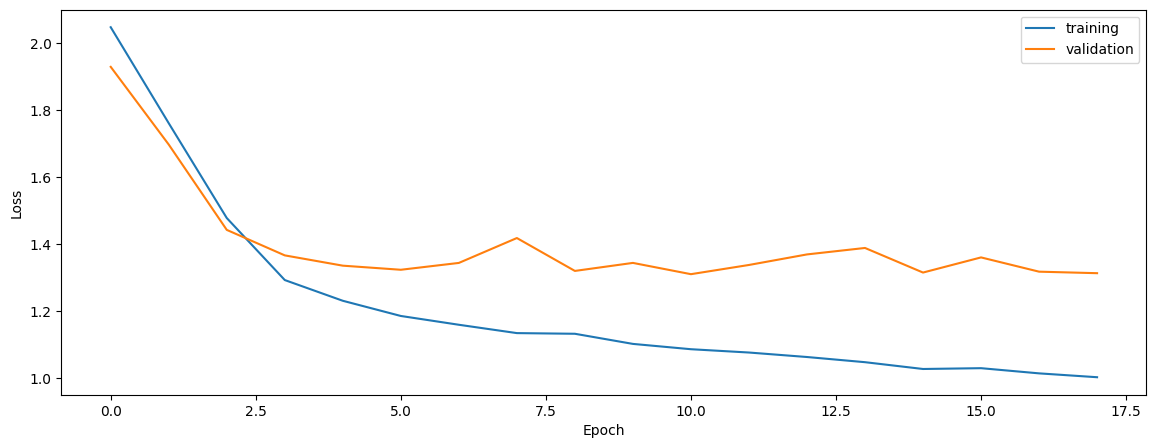

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.5685293053464189


0.4850319872302452


0.49523268400512604


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.5179258507836093


0.4855733554498232


0.46705211841454514


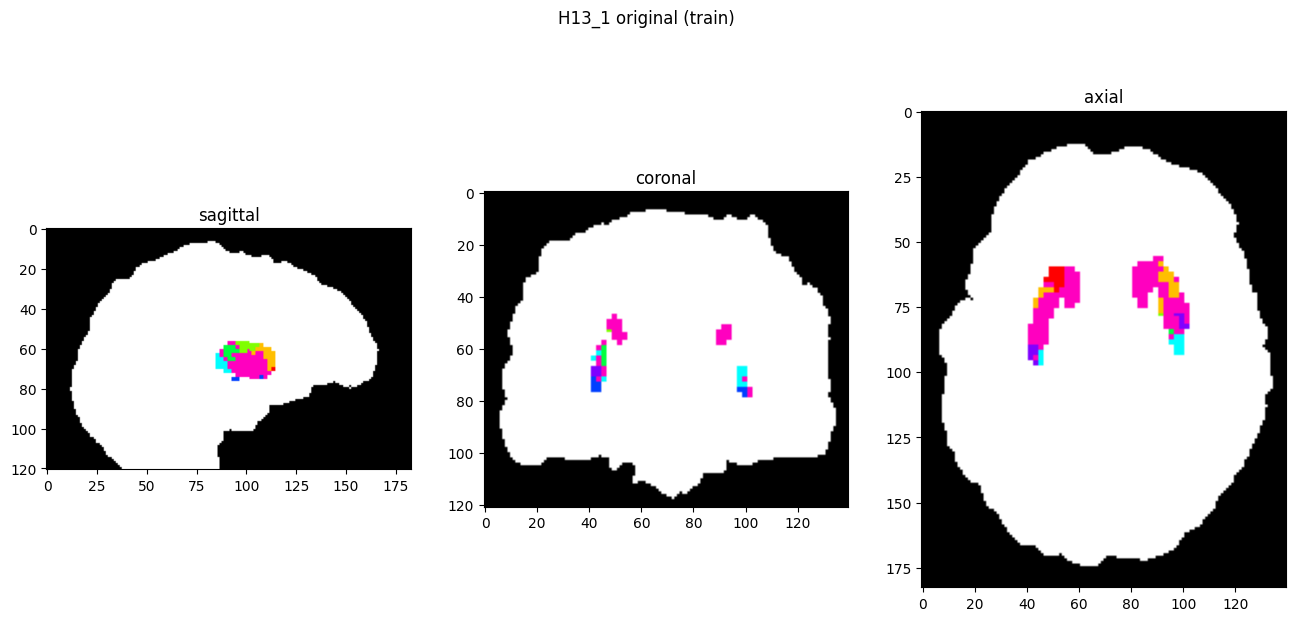

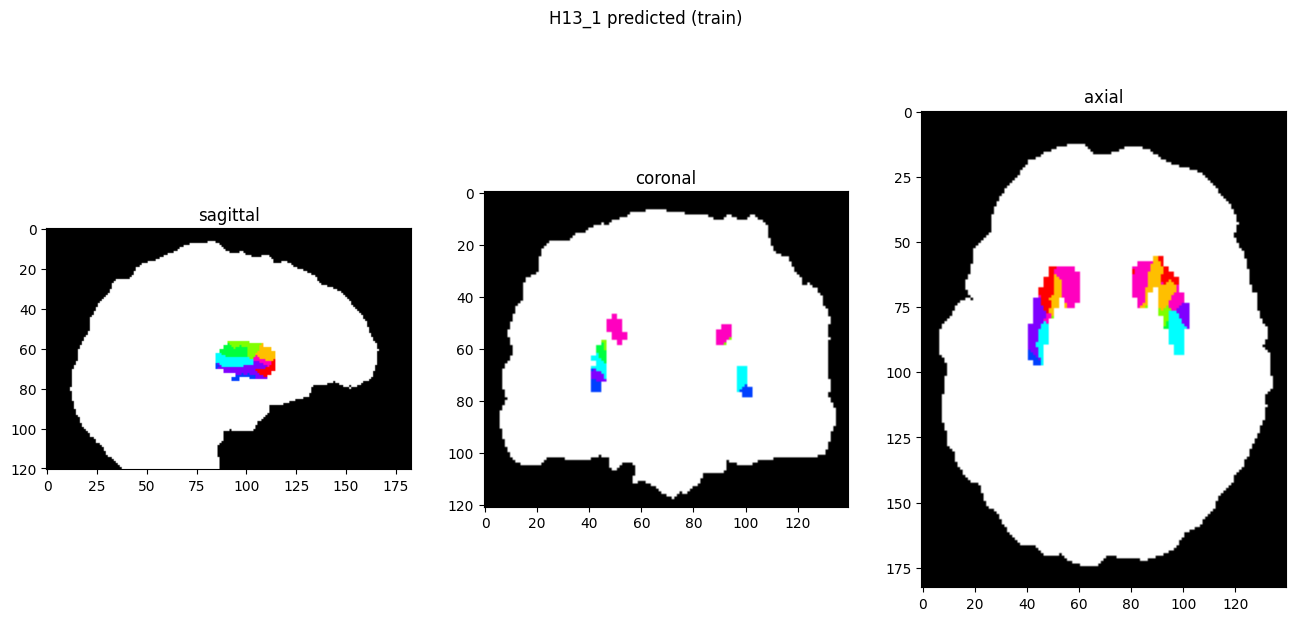

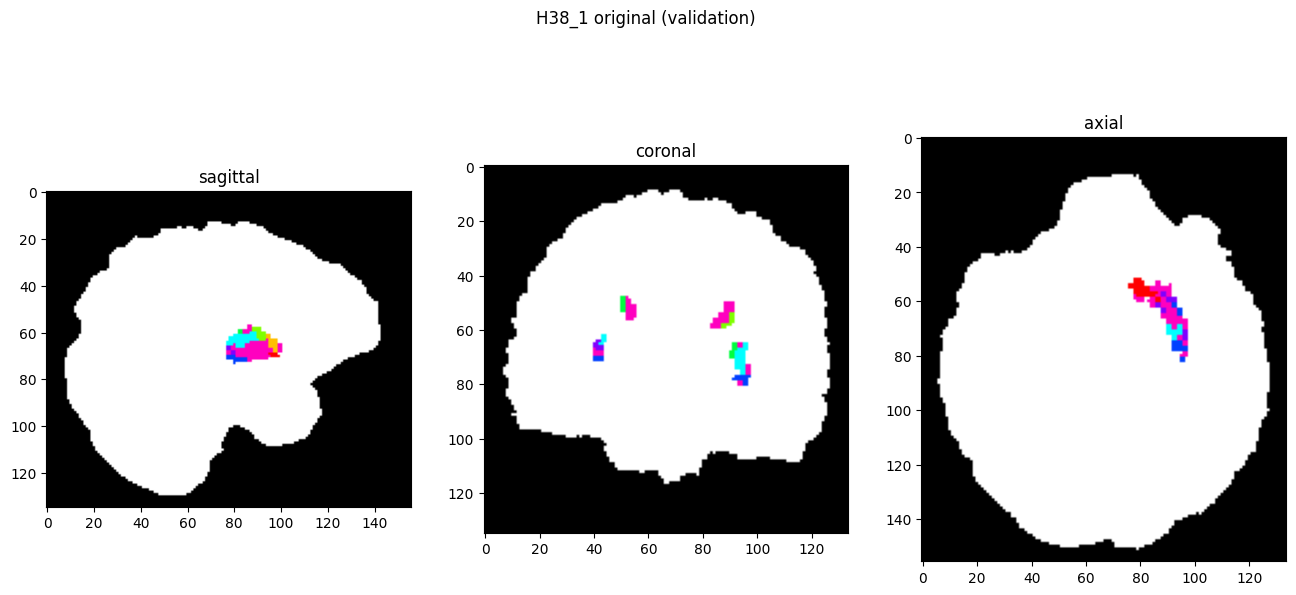

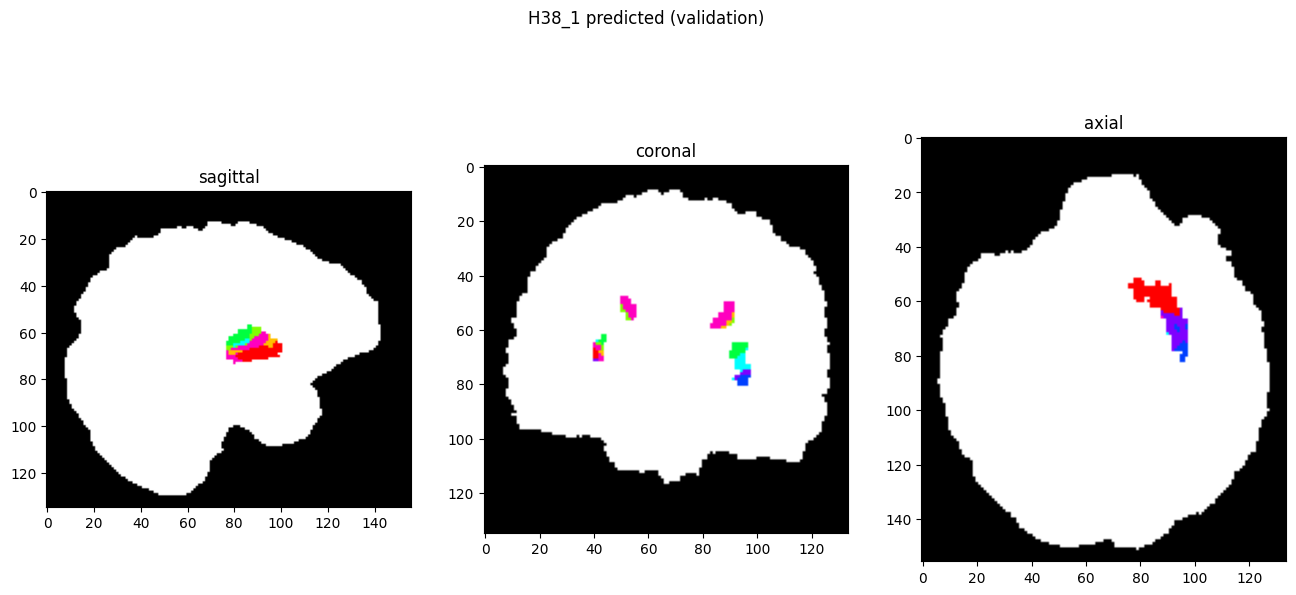

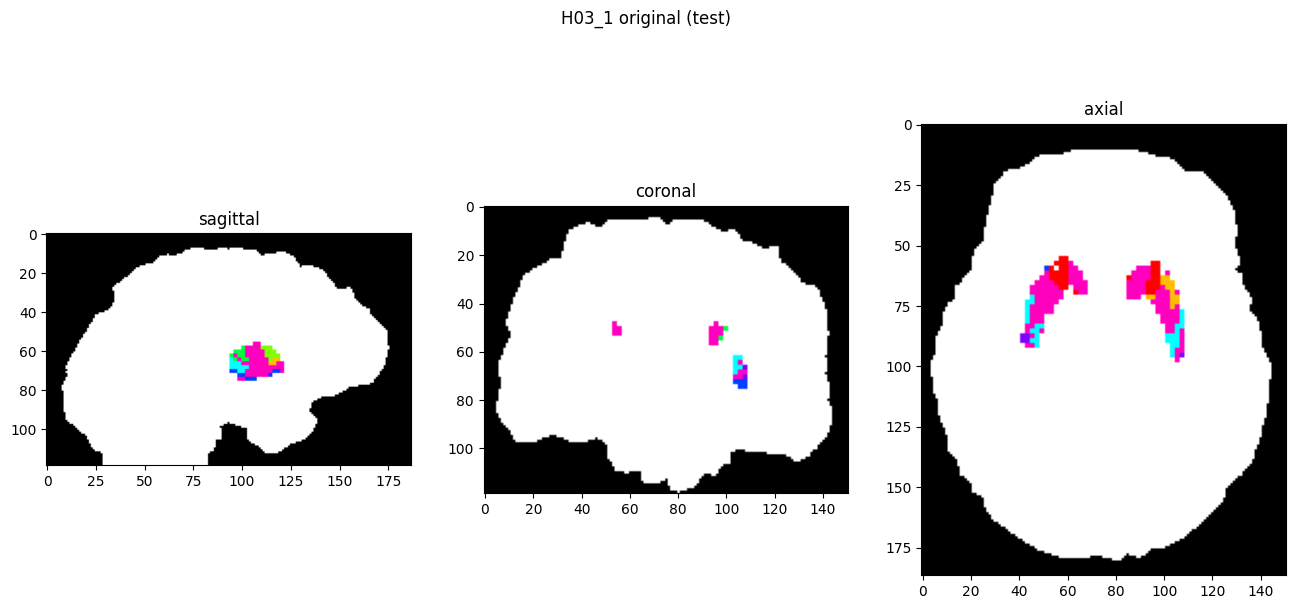

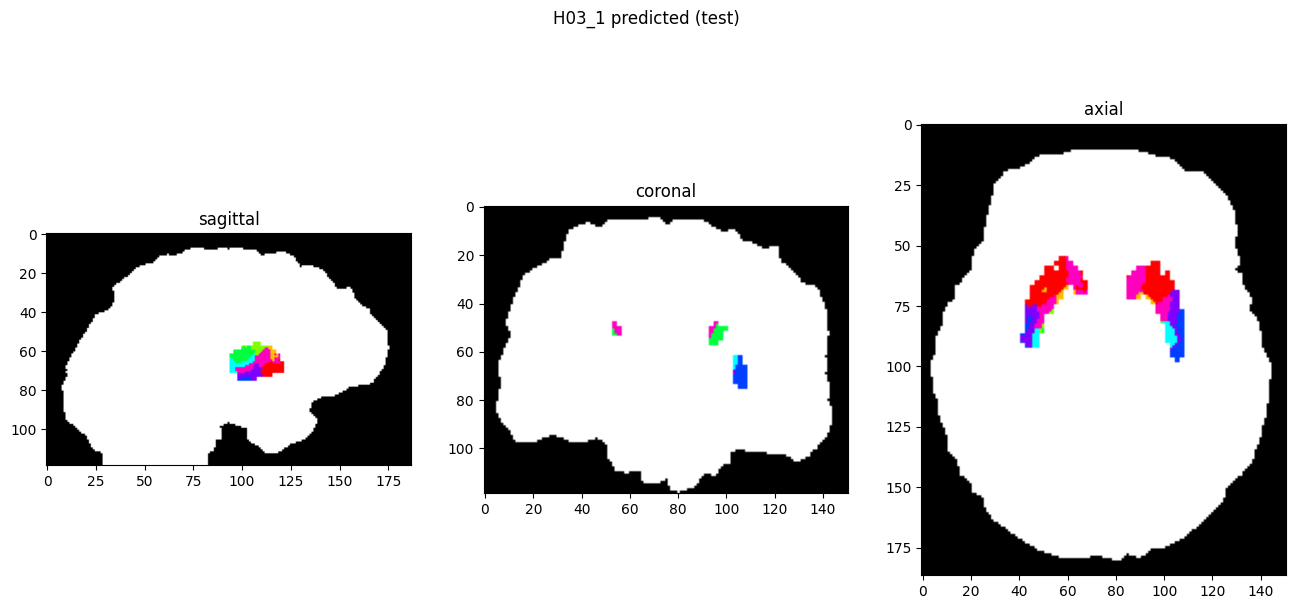

In [9]:
showResults(model, gen, threshold=0)